In [1]:
import os
import gc
import warnings

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats  as ss
from statsmodels.api import ProbPlot


warnings.filterwarnings(action = 'ignore')

In [2]:
train_transaction = pd.read_csv("../dataset/train_transaction.csv")
train_identity = pd.read_csv("../dataset/train_identity.csv")

test_transaction = pd.read_csv("../dataset/test_transaction.csv")
test_identity = pd.read_csv("../dataset/test_identity.csv")

In [3]:
train_df = pd.merge(left=train_transaction,right=train_identity,how='left',on = 'TransactionID')

In [4]:
del train_transaction, train_identity
gc.collect()

42

In [5]:
# Reduce_Memory_Usage(train_df)

In [6]:
# 类别、离散特征
cate_col_list = ['ProductCD','P_emaildomain','R_emaildomain','DeviceType','DeviceInfo','addr1','addr2']

#循环加入特征
for i in range(1,7):
    cate_col_list.append('card' + str(i))
for i in range(1 ,10):
    cate_col_list.append('M' + str(i))
for i in range(12 ,39):
    cate_col_list.append('id_' + str(i // 10) + str(i % 10))
#连续型特征
num_col_list = [x for x in train_df.columns if x not in cate_col_list]
num_col_list.remove('isFraud')

In [7]:
%run Cleaning_utils.ipynb

In [8]:
%run EDA_utils.ipynb

In [9]:
%run Featrue_Engineering_utils.ipynb

# Plan A: 先处理Outliers 再处理Missing Values

根据features的特性采用IQR和μ±3*σ的方式来检测异常值，和相适应的Outliers处理方法

In [10]:
print(cate_col_list , end= "")

['ProductCD', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo', 'addr1', 'addr2', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

## Feature ——ProductCD


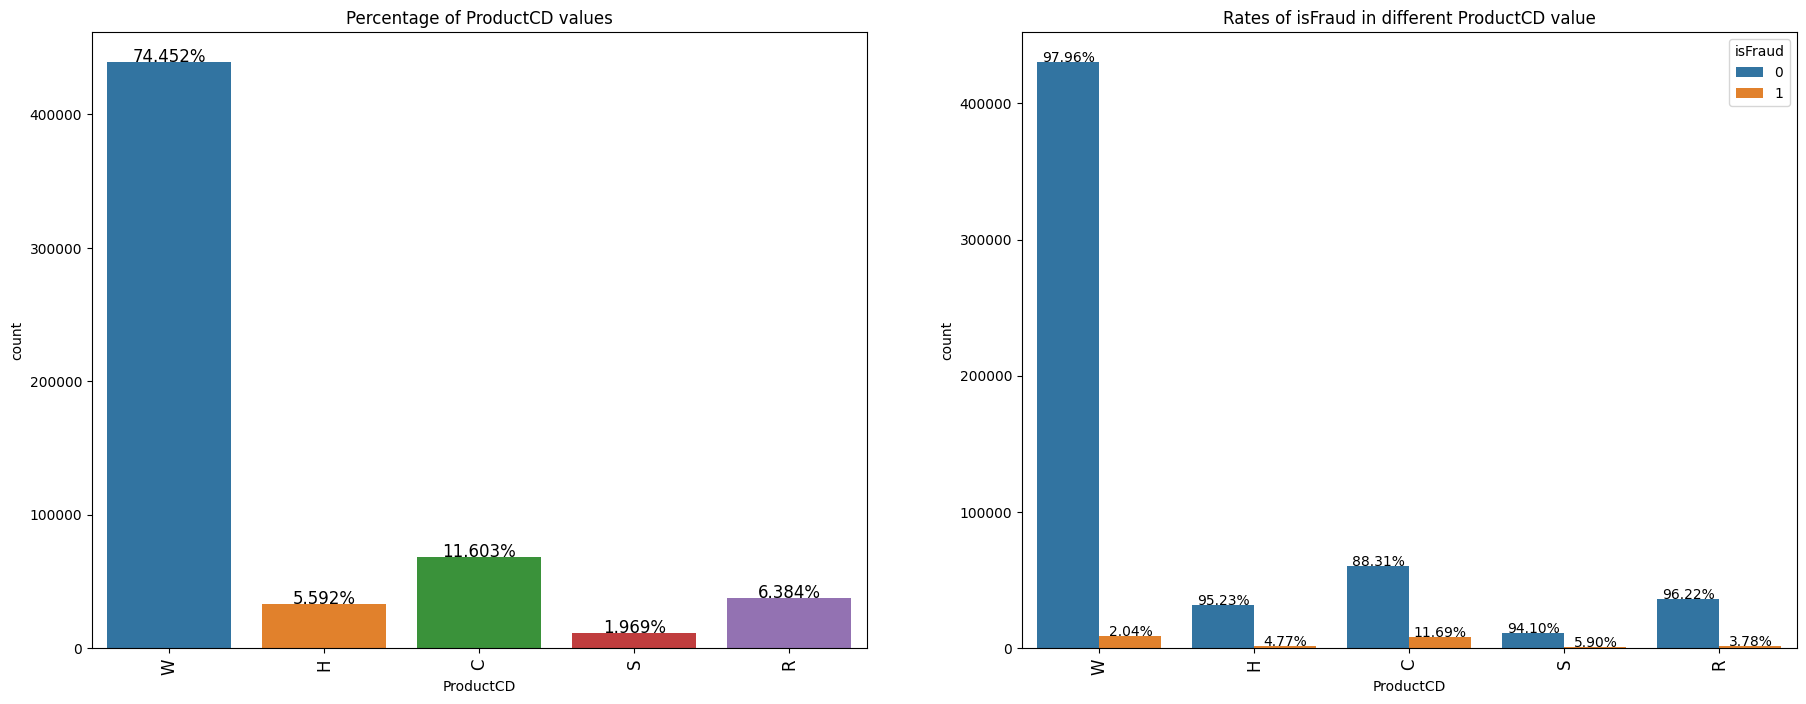

There is no Nan value in ProductCD


In [11]:
Plot_Cate_Feature(train_df, col = 'ProductCD', corr_col='isFraud')
Plot_Feature_Nan_Rate(train_df, col = 'ProductCD', label = 'isFraud')

In [12]:
# encoding 'ProductCD' with Sklearn Lablel encoder
temp_df = train_df[['ProductCD','isFraud']].copy()
temp_df['ProductCD'] = Encoder_With_Label(temp_df, col='ProductCD')

In [13]:
temp_df['ProductCD'].value_counts()

4.0    439670
0.0     68519
2.0     37699
1.0     33024
3.0     11628
Name: ProductCD, dtype: int64

1. when median as the foundment value

1.1 the upper bound value is 5.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 2.5
1.5 the potential outliers below 1.5IQR amount is : 139242
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              68519
2.0              37699
1.0              33024
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 4.720757246017456
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is 1.720757246017456
2.5 the potential outliers below 1.5IQR amount is : 101543
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              68

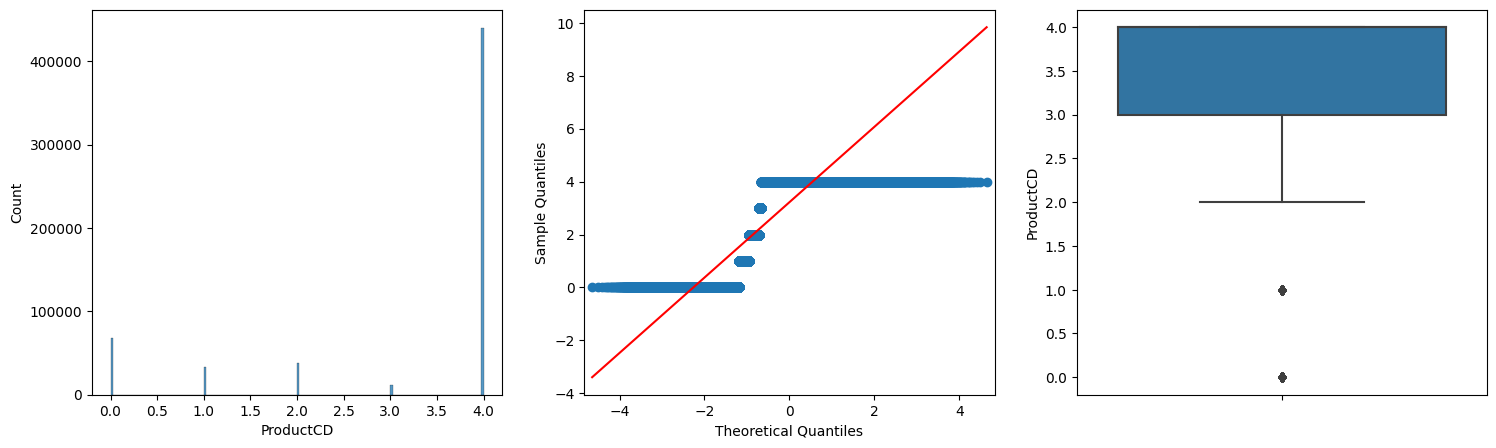

In [14]:
Outlier_Detect_IQR(data = temp_df, col = 'ProductCD')

after encoding, the total value types is 4,so, this feature 'ProductCD' may not follow normal distribution

Next, we should plot IQR figure to check whether there are some  Outliers

In [15]:
#according to analysis above , R，H，S may be outliers, 
#but the total percentage of R，H，S is more than 20%, so nothing to do may be better
train_df['ProductCD'].value_counts(normalize=True)
del temp_df
gc.collect()

18755

## P_emaildomain
- this feature may be the domian of user sign up email. 

- according to P_emaildomain,we can  know what speculate operators are popular.

In [16]:
#values of P_emaildomain are string type, so, encoding P_emaildomain is the first step
train_df['P_emaildomain'].value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com            230
t

In [17]:
#P_emaildomain contains  Nan  values, 
# Plot_Feature_Nan_Rate(train_df,col = 'P_emaildomain')
print("{} contain {} Nan values".format('P_emaildomain',train_df['P_emaildomain'].isnull().sum()))

P_emaildomain contain 94456 Nan values


In [18]:
#encoding P_emaildomain with labelencoder,
temp_df = train_df[['P_emaildomain','isFraud']].copy()
temp_df = Encoder_With_Label(temp_df,'P_emaildomain')

1. when median as the foundment value

1.1 the upper bound value is 38.5
1.2 the potential outliers above 1.5IQR amount is : 113431
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
54.0             100934
44.0               2970
49.0               2705
59.0               2396
55.0               1543
43.0                664
42.0                305
51.0                305
50.0                240
48.0                230
41.0                189
47.0                175
45.0                164
58.0                143
57.0                134
39.0                 76
56.0                 74
40.0                 68
53.0                 49
46.0                 35
52.0                 32
dtype: int64
1.4 the lower bound value is -6.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
--------------------------------------------------------------------------------------------

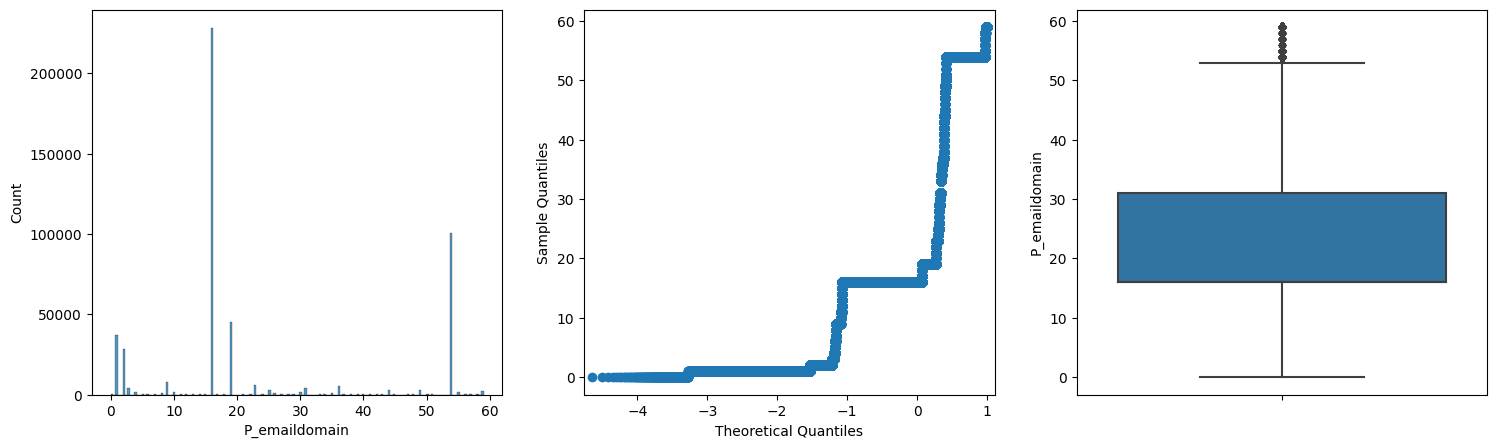

In [19]:
Outlier_Detect_IQR(temp_df, 'P_emaildomain')

In [20]:
#check values of P_emaildomain and value distribution
temp_df['P_emaildomain'].value_counts(normalize=True,ascending=True)

52.0    0.000065
46.0    0.000071
20.0    0.000087
53.0    0.000099
27.0    0.000113
40.0    0.000137
56.0    0.000149
39.0    0.000153
18.0    0.000226
57.0    0.000270
58.0    0.000288
17.0    0.000300
5.0     0.000321
45.0    0.000331
7.0     0.000347
47.0    0.000353
41.0    0.000381
14.0    0.000393
34.0    0.000395
6.0     0.000413
38.0    0.000417
33.0    0.000464
48.0    0.000464
50.0    0.000484
12.0    0.000524
13.0    0.000564
22.0    0.000595
42.0    0.000615
51.0    0.000615
21.0    0.000615
0.0     0.000635
24.0    0.000649
28.0    0.000879
37.0    0.000883
15.0    0.001000
11.0    0.001036
29.0    0.001127
43.0    0.001338
26.0    0.001510
8.0     0.001645
35.0    0.002038
10.0    0.002808
30.0    0.003068
55.0    0.003110
4.0     0.003848
59.0    0.004830
49.0    0.005453
44.0    0.005987
25.0    0.006130
3.0     0.008130
31.0    0.008249
36.0    0.010272
23.0    0.012633
9.0     0.015901
2.0     0.057025
1.0     0.074580
19.0    0.091214
54.0    0.203462
16.0    0.4603

In [21]:
del temp_df
gc.collect()

17772

after encoding of P_emaildomain ,54 may be a Outliers through IQR method
but, it take second percentage. So ,we can process this feature by rare feature method

## R_emaildomain

- this feature is similar to P_emaildomain
- encoding is first step, then check Outliers

In [22]:
train_df['R_emaildomain'].value_counts(normalize=True, ascending=False)

gmail.com           0.416247
hotmail.com         0.200370
anonymous.com       0.149529
yahoo.com           0.086255
aol.com             0.026957
outlook.com         0.018260
comcast.net         0.013198
yahoo.com.mx        0.010984
icloud.com          0.010183
msn.com             0.006206
live.com            0.005550
live.com.mx         0.005492
verizon.net         0.004516
me.com              0.004050
sbcglobal.net       0.004021
cox.net             0.003343
outlook.es          0.003154
att.net             0.003132
bellsouth.net       0.003074
hotmail.fr          0.002134
hotmail.es          0.002127
web.de              0.001726
mac.com             0.001588
ymail.com           0.001508
prodigy.net.mx      0.001508
optonline.net       0.001362
gmx.de              0.001071
yahoo.fr            0.000998
charter.net         0.000925
mail.com            0.000889
hotmail.co.uk       0.000765
gmail               0.000692
earthlink.net       0.000575
yahoo.de            0.000546
rocketmail.com

In [23]:
#encoding with labelencoder
temp_df = train_df[['R_emaildomain','isFraud']].copy()
temp_df = Encoder_With_Label(temp_df,'R_emaildomain')

1. when median as the foundment value

1.1 the upper bound value is 20.5
1.2 the potential outliers above 1.5IQR amount is : 24441
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
55.0             11842
36.0              2507
56.0              1508
23.0              1398
31.0               852
25.0               762
26.0               754
50.0               620
30.0               556
44.0               552
37.0               433
22.0               293
21.0               292
51.0               237
28.0               218
38.0               207
60.0               207
35.0               187
59.0               137
29.0               122
57.0                75
43.0                69
46.0                63
58.0                57
27.0                55
42.0                53
24.0                53
52.0                47
39.0                41
54.0                39
47.0                35
53.0                33
49.0                29
40.0                27
41.0   

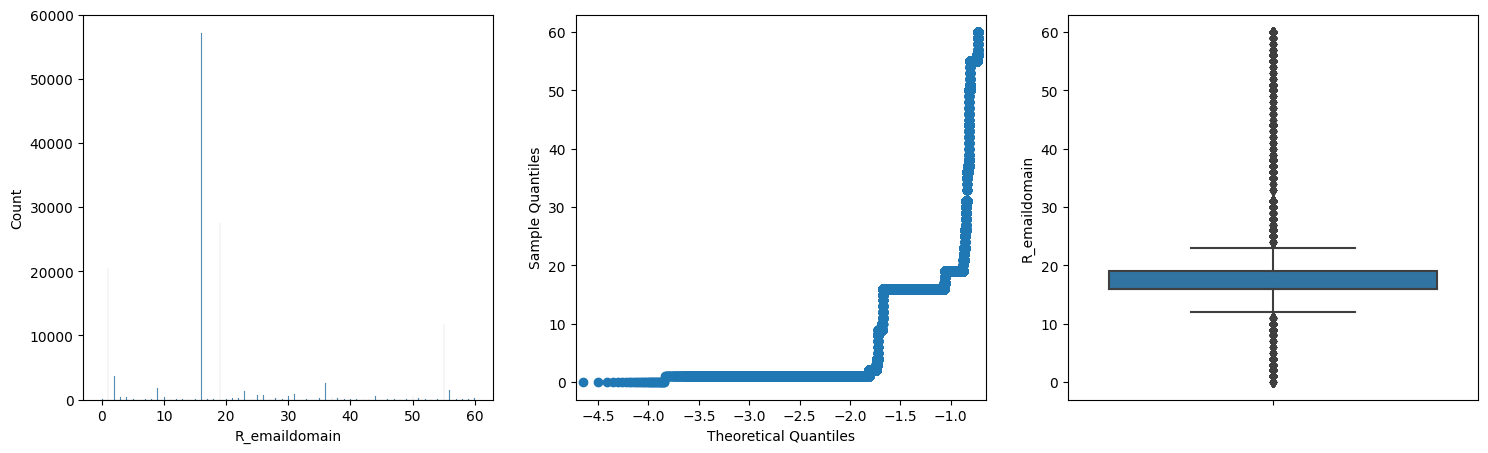

In [24]:
Outlier_Detect_IQR(temp_df, 'R_emaildomain')

In [25]:
del temp_df
gc.collect()

38954

because it original values are string type and labelencoder has randomness, Outliers detected by IQR 
may not be Outliers.

so we decide process this feature as rare feature

## DeviceType

In [26]:
train_df['DeviceType'].value_counts(normalize=True)

desktop    0.604822
mobile     0.395178
Name: DeviceType, dtype: float64

DeviceType only has two values, so  we just encoding it with binaryencoder


## DeviceInfo
deviceinfo may be the information about user device

In [27]:
train_df['DeviceInfo'].value_counts(normalize=True)

Windows        0.402154
iOS Device     0.166703
MacOS          0.105953
Trident/7.0    0.062697
rv:11.0        0.016020
                 ...   
LGMS345        0.000008
verykool       0.000008
XT1072         0.000008
LG-H931        0.000008
0PJA2          0.000008
Name: DeviceInfo, Length: 1786, dtype: float64

In [28]:
#DeviceInfo has many Nan value
train_df['DeviceInfo'].isnull().sum()

471874

In [29]:
#encode DeviceInfo firstly
temp_df = train_df[['DeviceInfo','isFraud']].copy()
temp_df = Encoder_With_Label(temp_df,'DeviceInfo')

1. when median as the foundment value

1.1 the upper bound value is 2210.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 986.0
1.5 the potential outliers below 1.5IQR amount is : 26403
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
723.0            12573
81.0               312
927.0              235
752.0              219
205.0              172
                 ...  
438.0                1
436.0                1
429.0                1
423.0                1
493.0                1
Length: 986, dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 1988.8135986328125
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int6

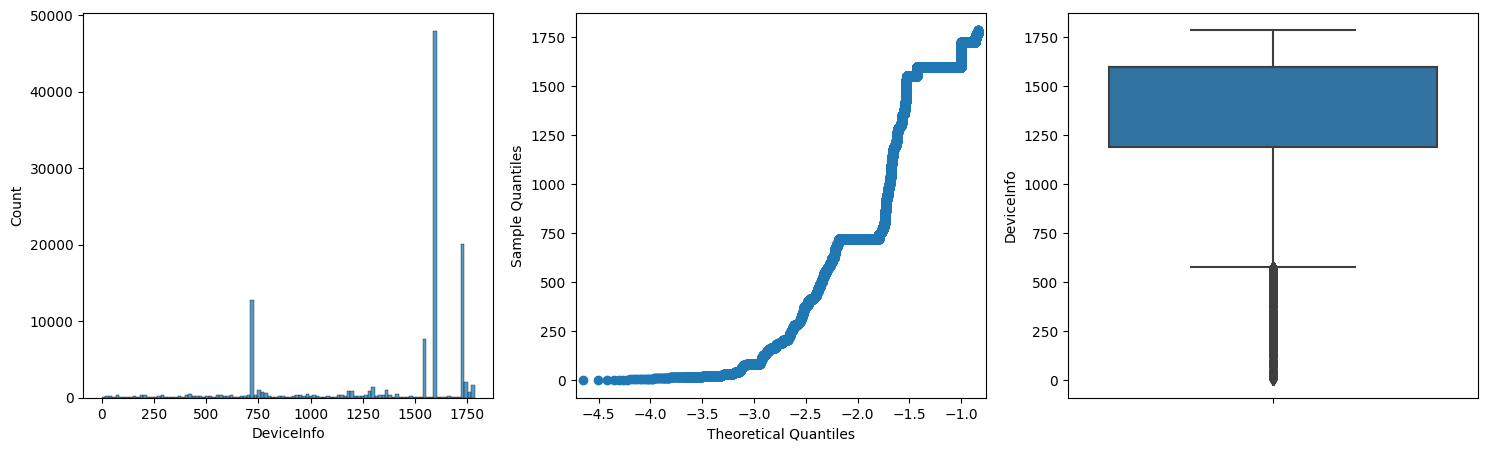

In [30]:
Outlier_Detect_IQR(temp_df, 'DeviceInfo')

these features which need encode firstly cann't confirm which part values are Outliers.

So, these extreme values can be handled as rare value 

## addr1
this feature may be some address of user 

In [31]:
#values of addr1 are integer type
#so we detect Outliers firstly
train_df['addr1'].value_counts(normalize=True)

299.0    0.088285
325.0    0.081456
204.0    0.080063
264.0    0.075967
330.0    0.050086
           ...   
386.0    0.000002
101.0    0.000002
353.0    0.000002
516.0    0.000002
245.0    0.000002
Name: addr1, Length: 332, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 488.0
1.2 the potential outliers above 1.5IQR amount is : 20576
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
512.0            8268
494.0            5065
498.0            4744
492.0             987
502.0             835
536.0             309
511.0             157
508.0              70
520.0              26
499.0              26
504.0              10
529.0               7
496.0               7
491.0               7
521.0               6
540.0               6
527.0               4
507.0               4
501.0               4
509.0               3
514.0               3
523.0               3
518.0               2
528.0               2
535.0               2
513.0               2
517.0               2
515.0               2
500.0               2
519.0               1
516.0               1
522.0               1
526.0               1
506.0               1
505.0               1
503.0             

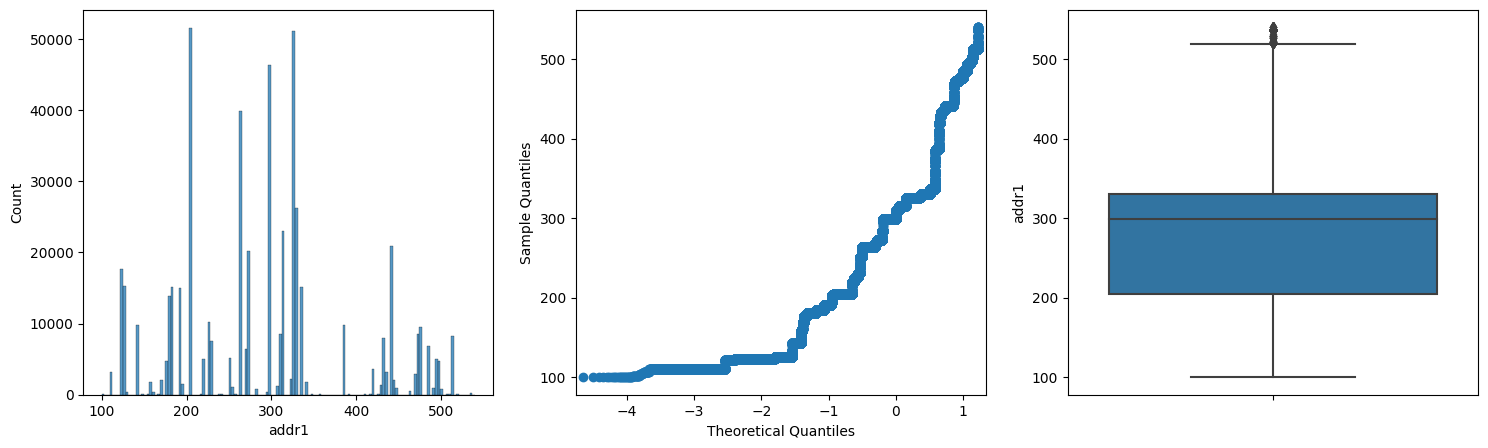

In [32]:
#addr1 拥有实数取值，因此可以直接的做异常值检测和处理
Outlier_Detect_IQR(train_df, 'addr1')

In [33]:
#handle Outliers with discretization
train_df['addr1'] = Outliers_Handle_Discretization(data = train_df, col = 'addr1',method = 'median')

## addr2

In [34]:
train_df['addr2'].value_counts(normalize=True)

87.0    0.991706
60.0    0.005876
96.0    0.001216
32.0    0.000173
65.0    0.000156
          ...   
49.0    0.000002
14.0    0.000002
25.0    0.000002
22.0    0.000002
93.0    0.000002
Name: addr2, Length: 74, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 87.0
1.2 the potential outliers above 1.5IQR amount is : 678
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
96.0             638
98.0              11
102.0             11
88.0               5
101.0              4
92.0               2
97.0               2
100.0              2
89.0               1
93.0               1
94.0               1
dtype: int64
1.4 the lower bound value is 87.0
1.5 the potential outliers below 1.5IQR amount is : 3675
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
60.0             3084
32.0               91
65.0               82
16.0               55
31.0               47
                 ... 
79.0                1
82.0                1
83.0                1
84.0                1
75.0                1
Length: 62, dtype: int64
----------------------------------------------------------------------------------------------------
2. when 

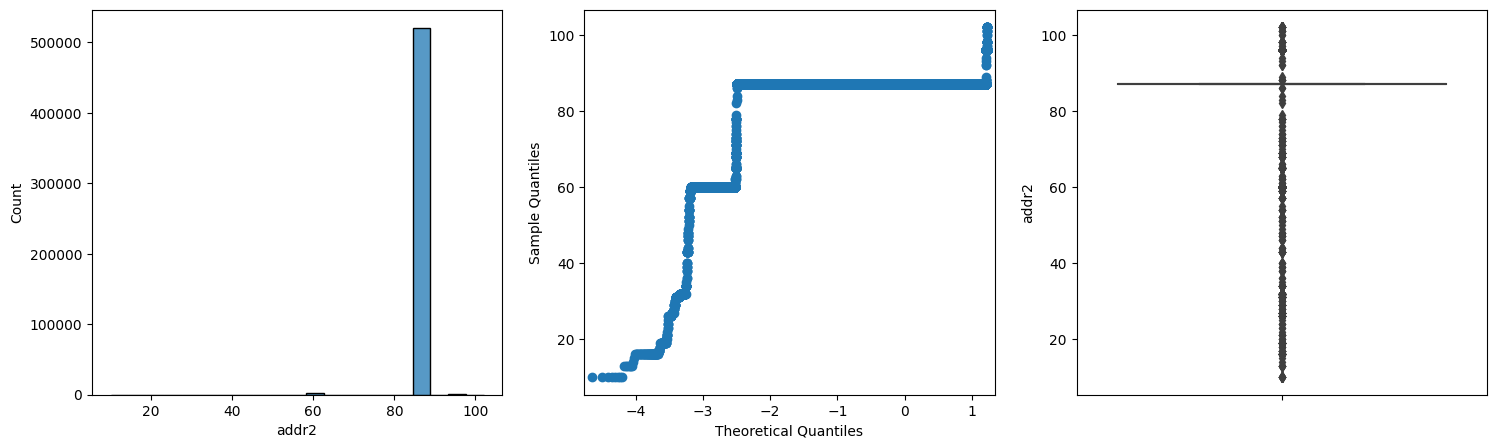

In [35]:
Outlier_Detect_IQR(train_df, 'addr2')

In [36]:
train_df['addr2'] = Outliers_Handle_Discretization(train_df, 'addr2', method = 'median')

## card1

In [37]:
train_df['card1'].value_counts(normalize=True)

7919     0.025285
9500     0.023981
15885    0.017545
17188    0.017516
15066    0.013454
           ...   
17084    0.000002
14620    0.000002
11440    0.000002
13231    0.000002
18038    0.000002
Name: card1, Length: 13553, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 21925.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is -2569.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 22146.234658109526
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -2348.765341890474
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


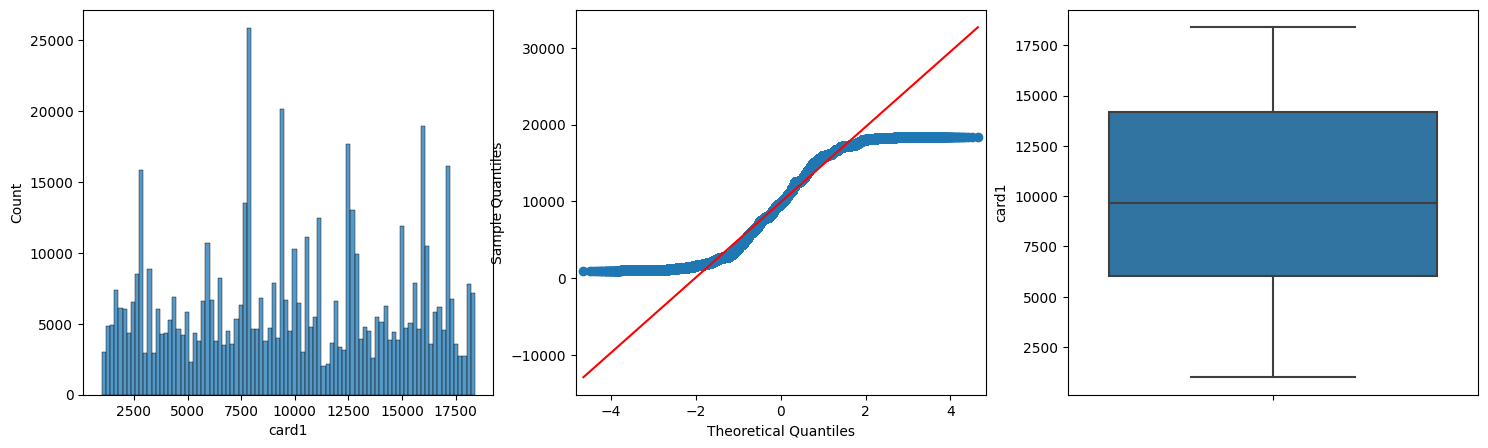

In [38]:
Outlier_Detect_IQR(train_df, 'card1')

- From this images above, we can confirm that feature 'card1' is uniform distribution. 

- Because its Q-Q shape is 's', we can confirm its variance is less than theorical expanded variance.

- The most important point is that there is no outliers in feature 'card1' for the reason of uniform distribution



## card2

In [39]:
train_df['card2'].value_counts(normalize= True)

321.0    0.084138
111.0    0.077700
555.0    0.072205
490.0    0.065586
583.0    0.037488
           ...   
388.0    0.000067
153.0    0.000065
557.0    0.000064
473.0    0.000031
582.0    0.000024
Name: card2, Length: 500, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 808.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is -86.0
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 809.5554884999665
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -84.44451150003351
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


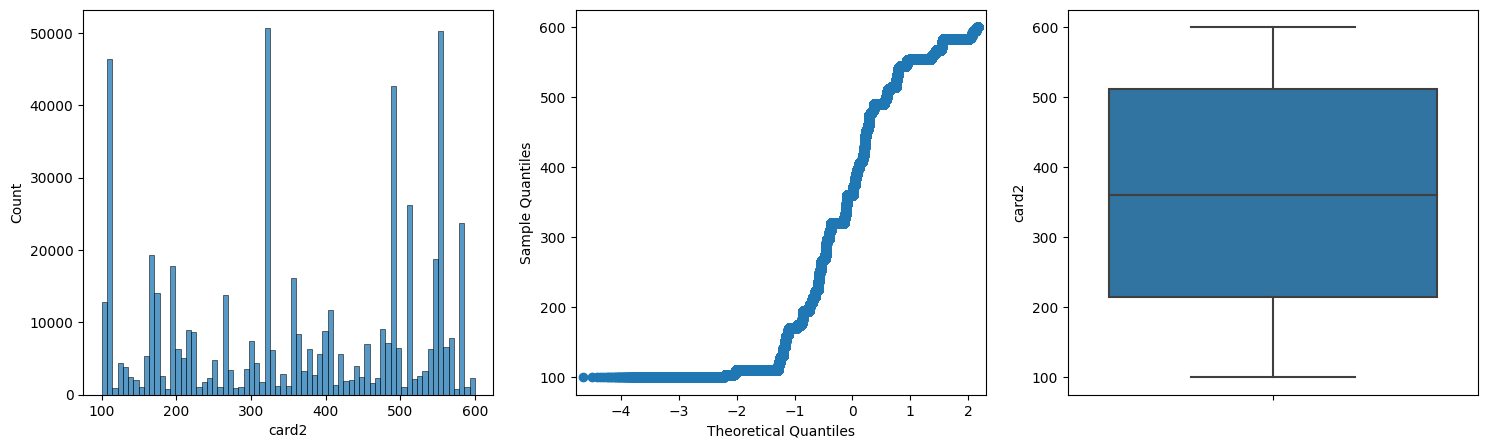

In [40]:
Outlier_Detect_IQR(train_df, col = 'card2')

- The feature 'card2' is approximate  uniform distribution.  
- The shape of Q-Q plot is like 's'
- There is also no outliers which are detected by IQR method

## card3

In [41]:
train_df['card3'].value_counts(dropna= False, normalize=True)

150.0    0.882729
185.0    0.095414
106.0    0.002660
NaN      0.002650
144.0    0.002120
           ...   
199.0    0.000002
221.0    0.000002
209.0    0.000002
132.0    0.000002
173.0    0.000002
Name: card3, Length: 115, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 150.0
1.2 the potential outliers above 1.5IQR amount is : 58738
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
185.0            56346
162.0              339
203.0              253
213.0              221
200.0              184
                 ...  
224.0                1
201.0                1
228.0                1
199.0                1
173.0                1
Length: 71, dtype: int64
1.4 the lower bound value is 150.0
1.5 the potential outliers below 1.5IQR amount is : 8950
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
106.0            1571
146.0            1252
144.0            1252
117.0             962
143.0             899
119.0             750
102.0             460
147.0             390
100.0             202
131.0             172
134.0             166
149.0             127
135.0             120
121.0              99
137.0              71
138.0   

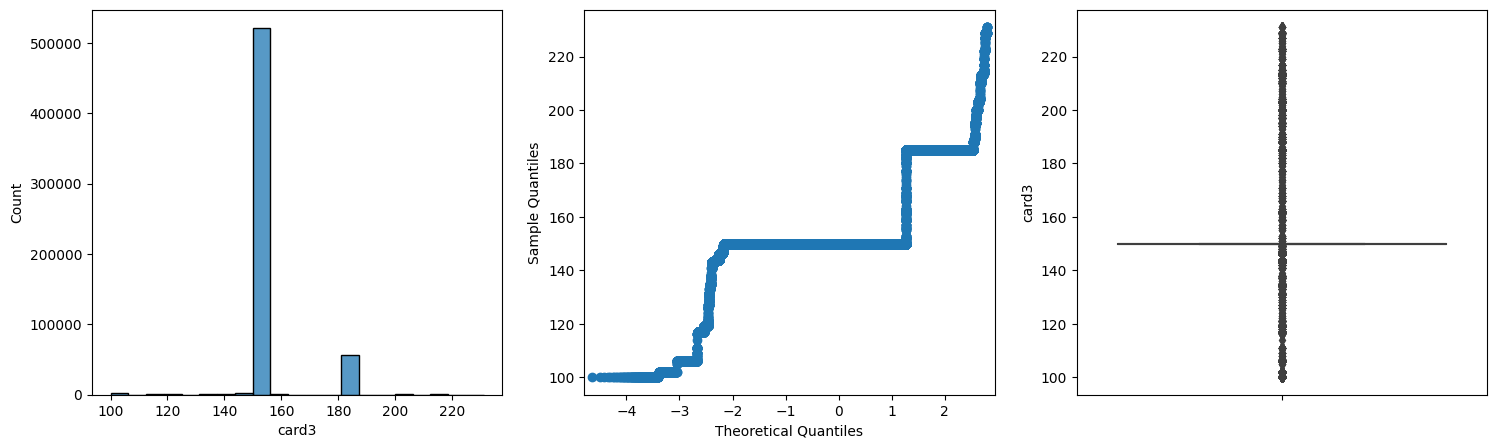

In [42]:
Outlier_Detect_IQR(data = train_df, col = 'card3')

According to IQR methon, if we discretize outliers there will be only a value 150 left. 

So, we can't discretize outliers directly.

Obviously, we should handle this feature differently.

In [43]:
#values except for 150 and 185 are classified into other value 0
train_df['card3'] = train_df['card3'].apply(lambda x : x if x == 150 or x == 185 else 0)

In [44]:
train_df['card3'].value_counts()

150.0    521287
185.0     56346
0.0       12907
Name: card3, dtype: int64

## card4

In [45]:
train_df['card4'].value_counts(dropna= False,normalize=True)

visa                0.651551
mastercard          0.320414
american express    0.014102
discover            0.011263
NaN                 0.002670
Name: card4, dtype: float64

In [46]:
#encoding card4 with Labelencoder firstly
temp_df = train_df[['card4','isFraud']].copy()
temp_df['card4'] = Encoder_With_Label(train_df, col = 'card4')

In [47]:
#after encoding
temp_df['card4'].value_counts(dropna= False,normalize = True)

4.0    0.651551
2.0    0.320414
0.0    0.014102
1.0    0.011263
NaN    0.002670
Name: card4, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 7.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 1.0
1.5 the potential outliers below 1.5IQR amount is : 8328
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              8328
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 6.267018556594849
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is 0.26701855659484863
2.5 the potential outliers below 1.5IQR amount is : 8328
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              8328
dtype: int64


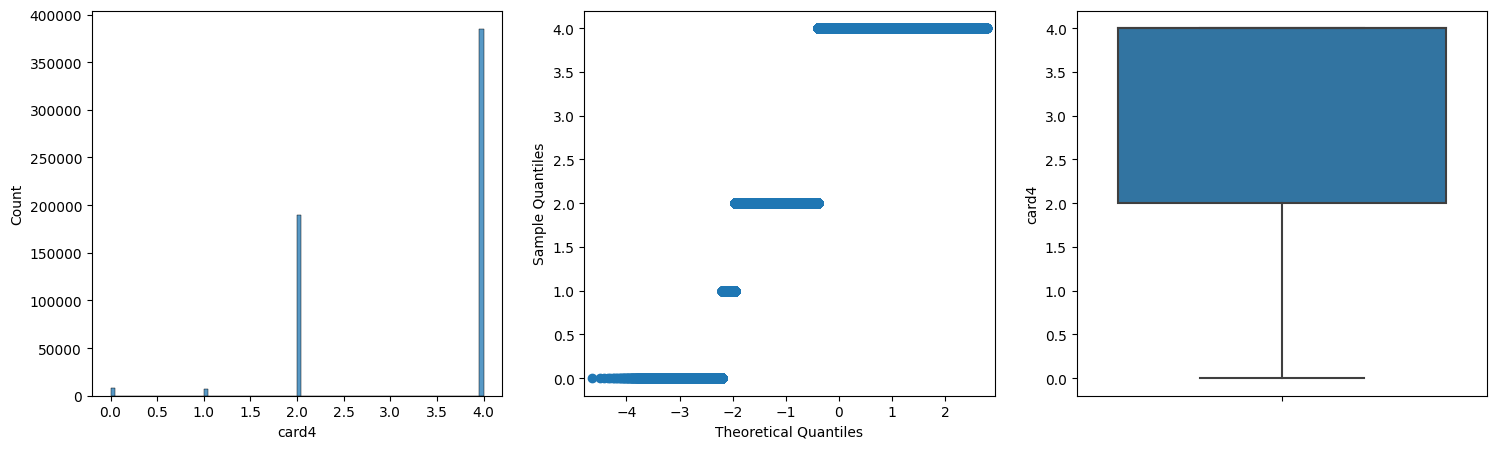

In [48]:
Outlier_Detect_IQR(data = temp_df, col = 'card4')

Although IQR method doesn't detect outliers '1',  the percentage of 1 and 0 are both less.

So, it's necessary to check wheather there exist fraud sample which have card4 value if 0 and 1

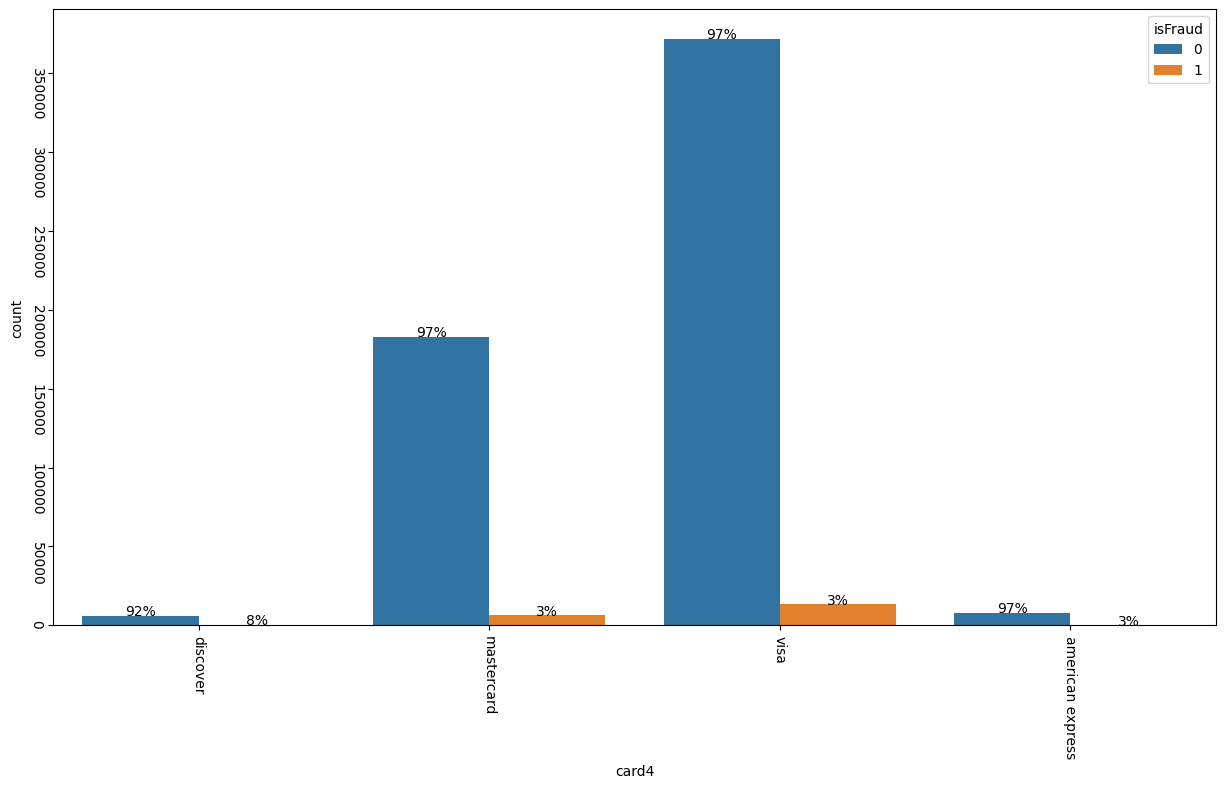

In [49]:
Plot_Cate_Correlation(data = train_df, col_A = 'card4', hue_B='isFraud', is_percentage=True)

after showing the percentage of 'isFraud' in 'card4'，we can find that fraud rate is high when card4 value is 1. But fraud rate is same when card4 is other values 

so, we modify card4 value 0 to 4 or 2

In [50]:
#modify card4 value 0 to 4
train_df['card4'] = train_df['card4'].apply(lambda x : 4 if x == 0 else x)

## card5

In [51]:
train_df['card5'].value_counts(normalize=True)

226.0    0.505809
224.0    0.139034
166.0    0.097462
102.0    0.049643
117.0    0.044247
           ...   
221.0    0.000002
167.0    0.000002
115.0    0.000002
165.0    0.000002
234.0    0.000002
Name: card5, Length: 119, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 316.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 136.0
1.5 the potential outliers below 1.5IQR amount is : 68613
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
102.0            29105
117.0            25941
126.0            10298
100.0              978
118.0              752
129.0              325
119.0              219
131.0              205
132.0              203
135.0              196
133.0              145
134.0               94
111.0               25
127.0               25
104.0               23
130.0               12
107.0               12
121.0               12
101.0                7
122.0                5
106.0                5
116.0                5
128.0                3
114.0                3
112.0                3
109.0                3
123.0     

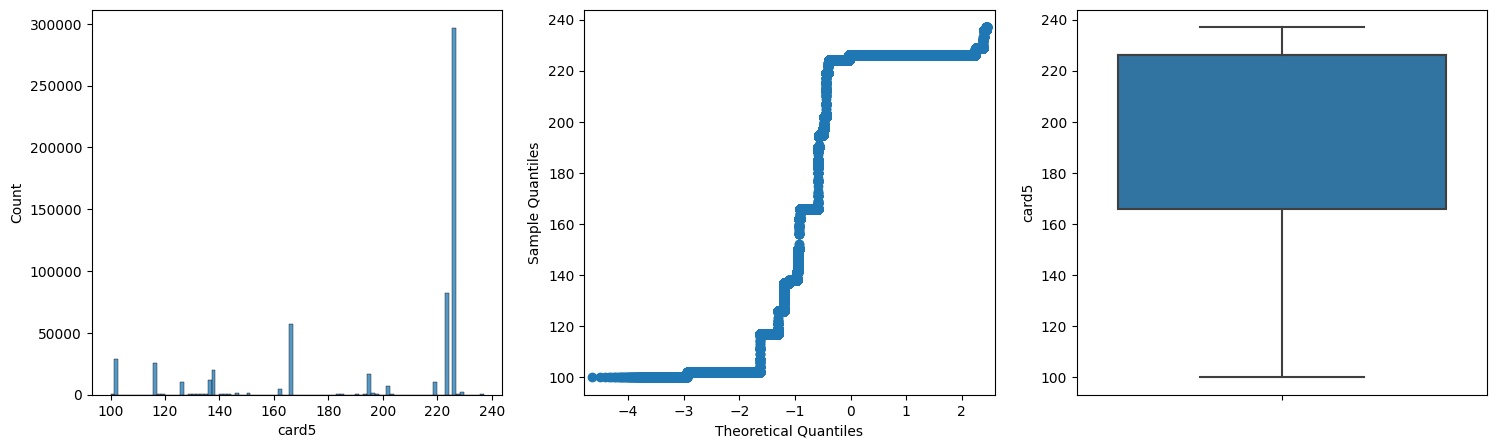

In [52]:
Outlier_Detect_IQR(data = train_df, col ='card5')

In [53]:
#discretize feature card5 outliers with value -9999
train_df['card5'] = Outliers_Handle_Discretization(data = train_df, col ='card5', method='median',value = -9999)

## card6

In [54]:
train_df['card6'].value_counts(normalize=True, dropna=False)

debit              0.744976
credit             0.252288
NaN                0.002660
debit or credit    0.000051
charge card        0.000025
Name: card6, dtype: float64

In [55]:
#encoding card6 firstly
temp_df = train_df[['card6','isFraud']].copy()
temp_df['card6'] = Encoder_With_Label(data = temp_df, col = 'card6')

1. when median as the foundment value

1.1 the upper bound value is 3.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 0.5
1.5 the potential outliers below 1.5IQR amount is : 15
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              15
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 3.247039318084717
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is 0.2470393180847168
2.5 the potential outliers below 1.5IQR amount is : 15
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              15
dtype: int64


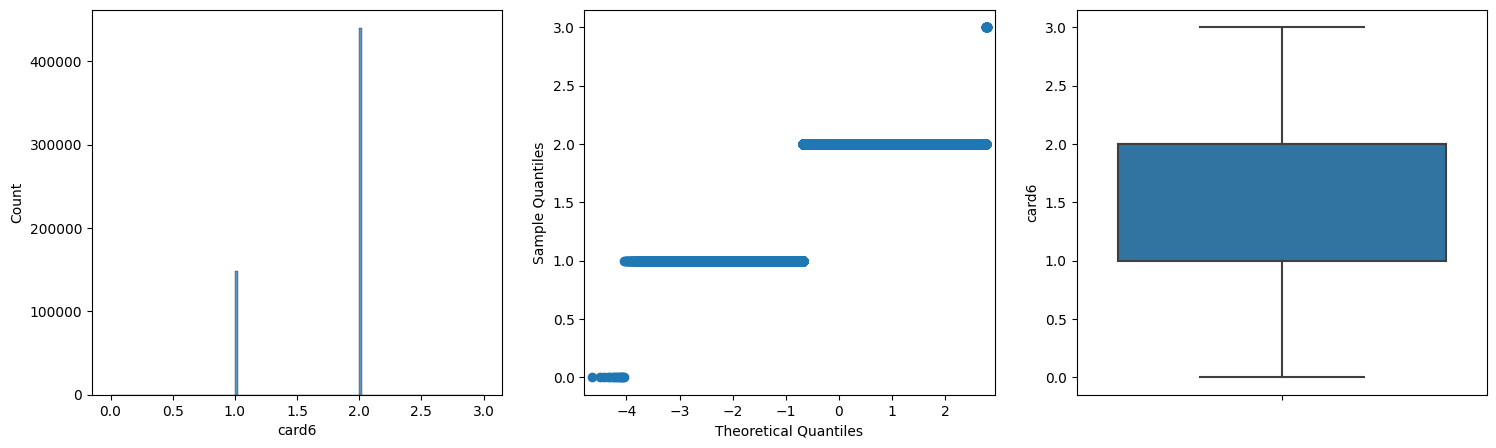

In [56]:
Outlier_Detect_IQR(data = temp_df, col = 'card6')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


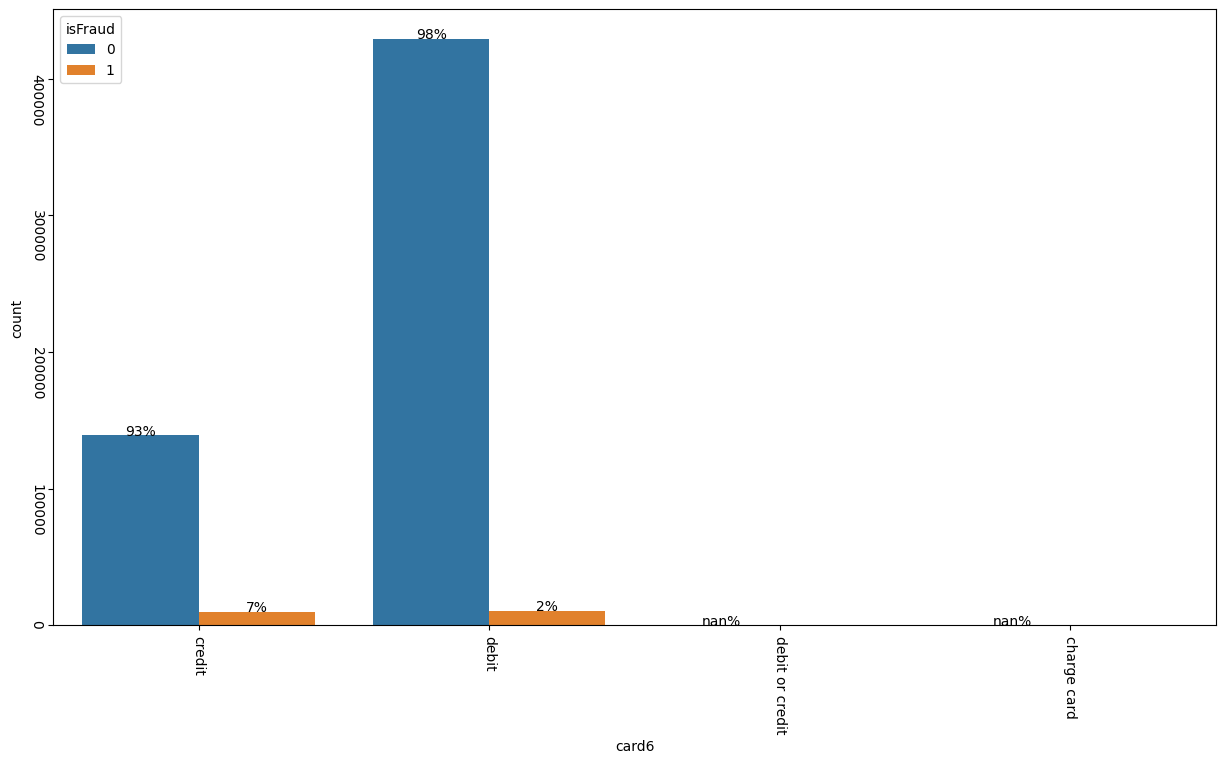

In [57]:
Plot_Cate_Correlation(data = train_df, col_A='card6', hue_B='isFraud',is_percentage=True)

According to image above, we can find that there is no fraud samples  when card6 value is 0 or 3

Moreover, their percentages are small. So,we can modify card6 value 0 and 3 to 2

In [58]:
train_df['card6'] = train_df['card6'].apply(lambda x : 2 if x == 0 or x == 3 else x )

In [59]:
train_df['card6'].value_counts()

debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64

In [60]:
del temp_df
gc.collect()

19784

## M1

In [61]:
train_df['M1'].value_counts(normalize=True)

T    0.999922
F    0.000078
Name: M1, dtype: float64

In [62]:
#there only two values in feature M1,so we take onehot encoder method to encode 'M1' directly
temp_df = train_df[['M1','isFraud']].copy()
temp_df['M1'] = Encoder_With_Label(data = temp_df, col = 'M1')

In [63]:
temp_df['M1'].value_counts(normalize = True)

1.0    0.999922
0.0    0.000078
Name: M1, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 1.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 1.0
1.5 the potential outliers below 1.5IQR amount is : 25
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              25
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 0.9999217391014099
2.2 the potential outliers above 1.5IQR amount is : 319415
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
1.0              319415
dtype: int64
2.4 the lower bound is 0.9999217391014099
2.5 the potential outliers below 1.5IQR amount is : 25
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              25
dtype: int64


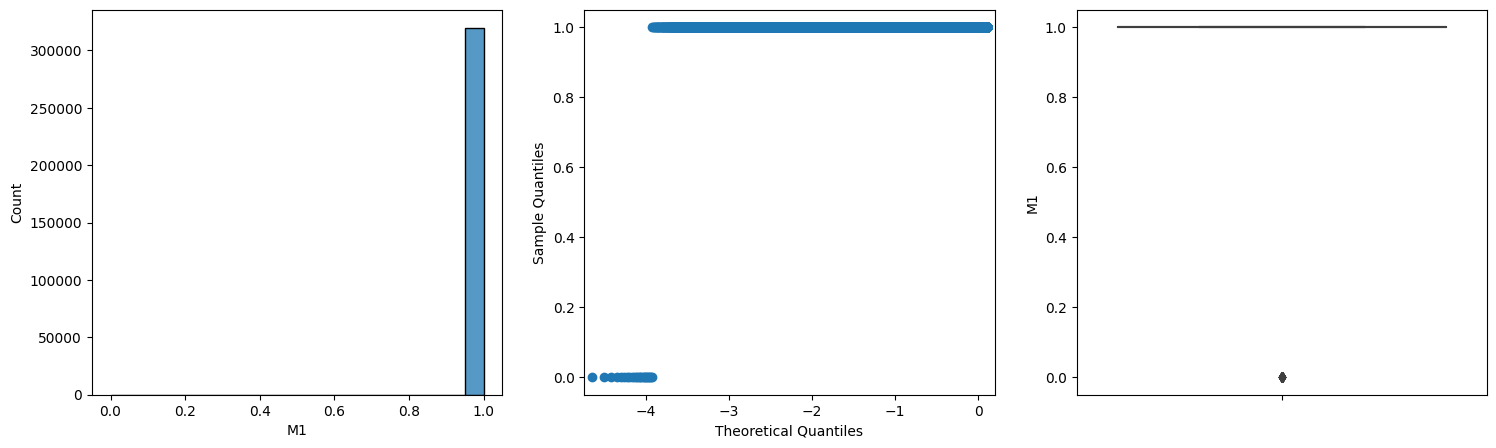

In [64]:
Outlier_Detect_IQR(data = temp_df, col = 'M1')

posx and posy should be finite values
posx and posy should be finite values


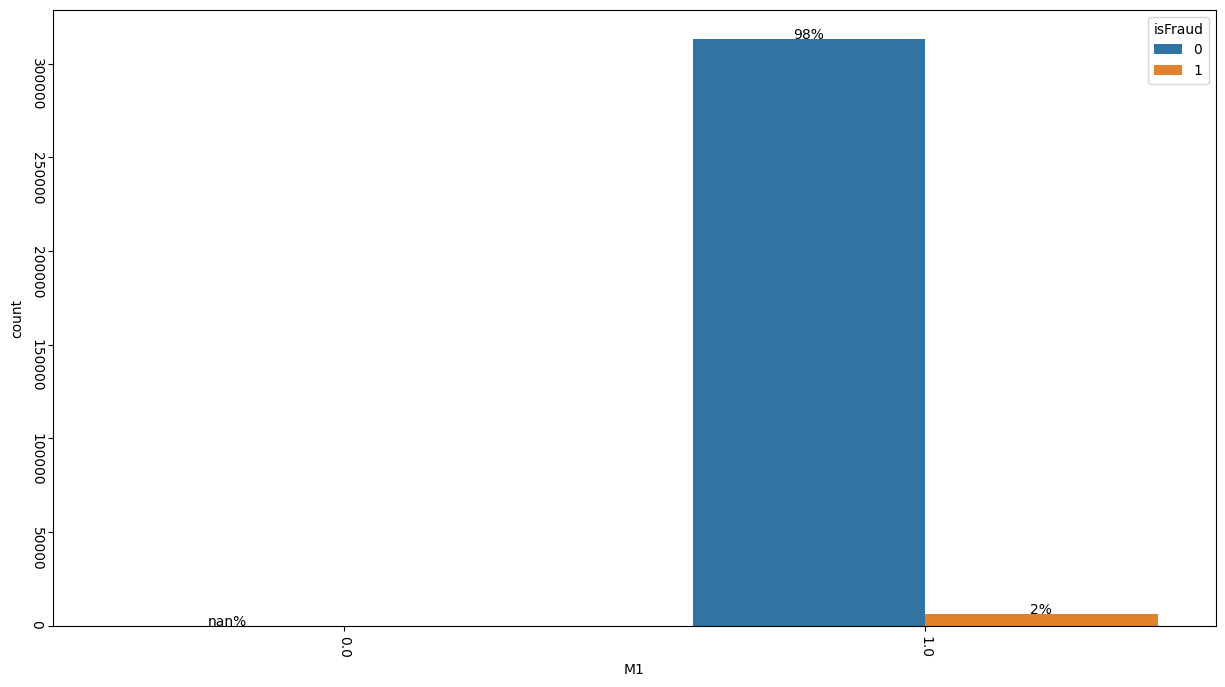

In [65]:
Plot_Cate_Correlation(data = temp_df, col_A='M1', hue_B='isFraud', is_percentage=True)

According to images above, we can sure that M1 with value 0 has no fraud samples, so we can delete it directly. 

Because M1 takes a small percentage when its value is 0. If we modify its value to 1, M1 has only a value which has no effect on model. 

In [66]:
del temp_df
gc.collect()

12906

## M2

In [67]:
train_df['M2'].value_counts(normalize=True)

T    0.893651
F    0.106349
Name: M2, dtype: float64

In [68]:
#Encoding M2 firstly
temp_df = train_df[['M2','isFraud']].copy()
temp_df['M2'] = Encoder_With_Label(data = temp_df, col = 'M2')

1. when median as the foundment value

1.1 the upper bound value is 1.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 1.0
1.5 the potential outliers below 1.5IQR amount is : 33972
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              33972
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 0.8936513662338257
2.2 the potential outliers above 1.5IQR amount is : 285468
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
1.0              285468
dtype: int64
2.4 the lower bound is 0.8936513662338257
2.5 the potential outliers below 1.5IQR amount is : 33972
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              33972
dtype: int6

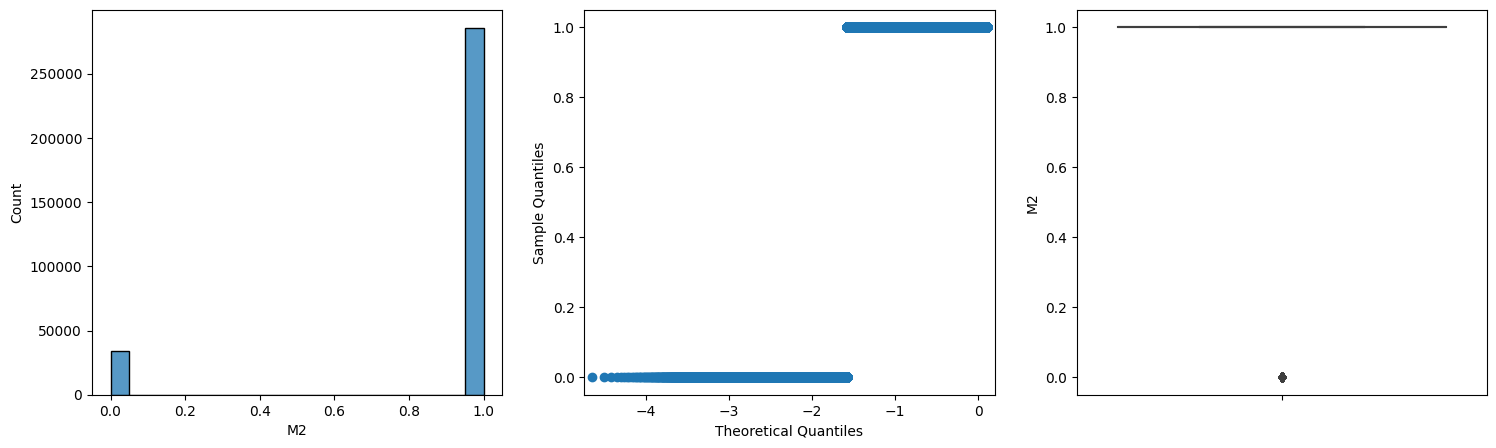

In [69]:
Outlier_Detect_IQR(data = temp_df, col= 'M2')

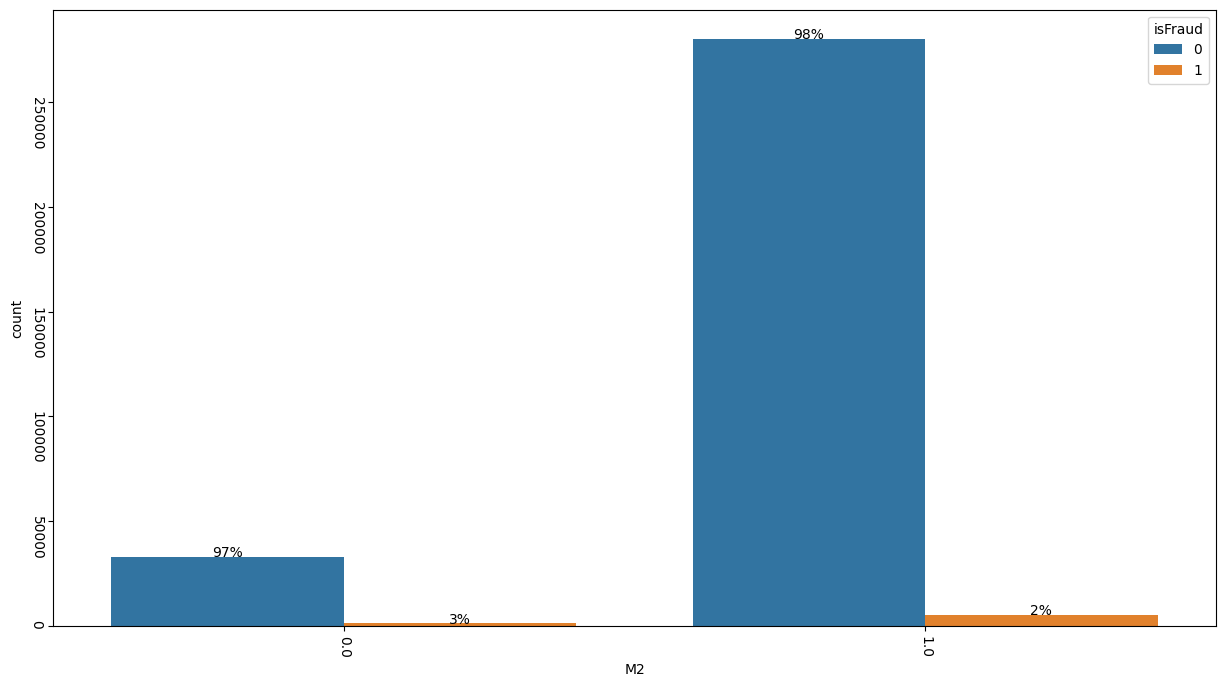

In [70]:
Plot_Cate_Correlation(data = temp_df, col_A= 'M2', hue_B='isFraud', is_percentage=True)

Although the percentage of M2 is small when value is 0, the Fraud sample has a 3% percentage. so,we 
can't handle outlier 0 according to IQR method.

we just encode it whit labelencoder.

In [71]:
del temp_df
gc.collect()

12753

## M3

In [72]:
train_df['M3'].value_counts(normalize=True)

T    0.788038
F    0.211962
Name: M3, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 1.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 1.0
1.5 the potential outliers below 1.5IQR amount is : 67709
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              67709
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 0.788038432598114
2.2 the potential outliers above 1.5IQR amount is : 251731
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
1.0              251731
dtype: int64
2.4 the lower bound is 0.788038432598114
2.5 the potential outliers below 1.5IQR amount is : 67709
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              67709
dtype: int64


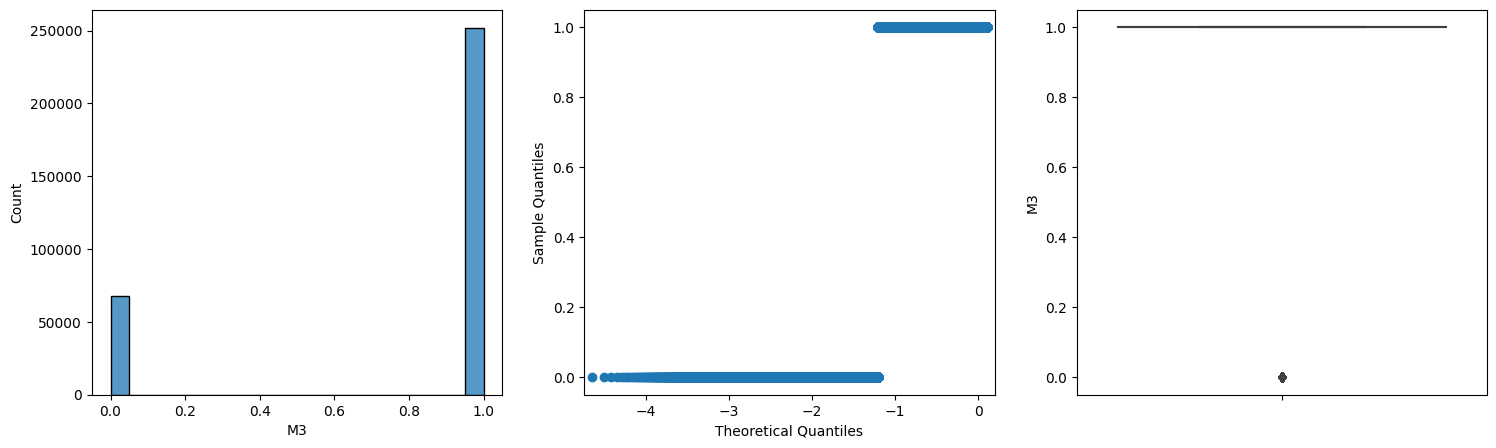

In [73]:
#encode M3 firstly
temp_df = train_df[['M3','isFraud']].copy()
temp_df['M3'] = Encoder_With_Label(data = temp_df, col = 'M3')
Outlier_Detect_IQR(data = temp_df, col='M3')

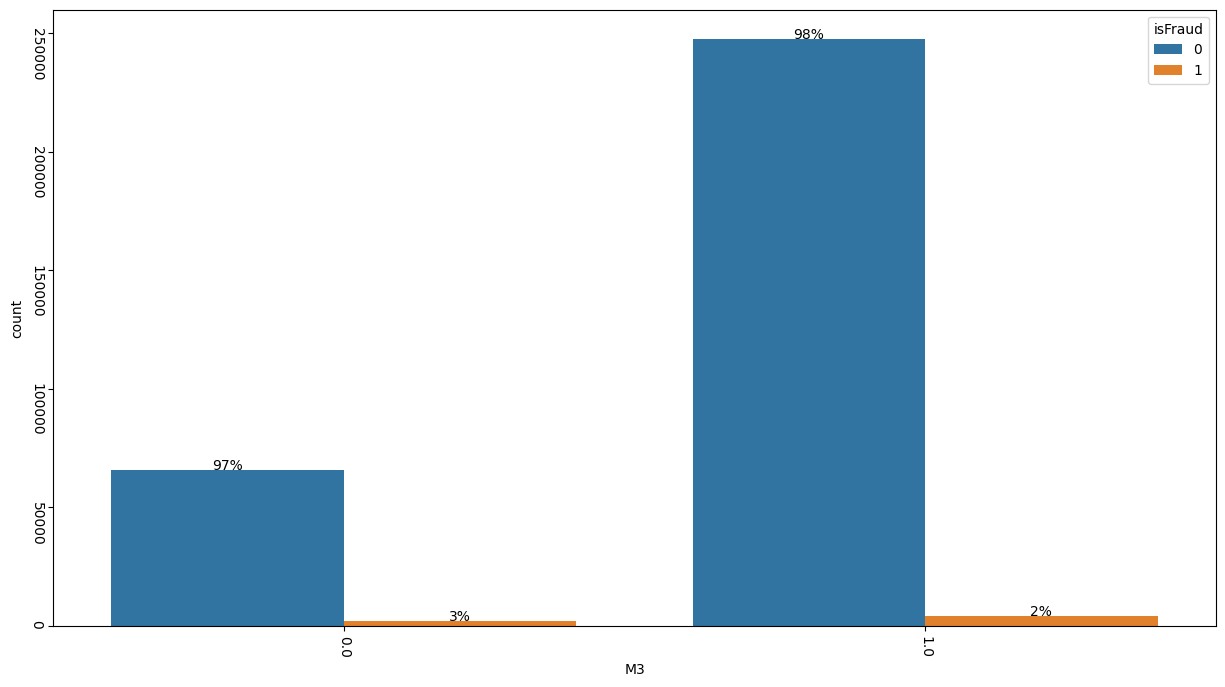

In [74]:
Plot_Cate_Correlation(data = temp_df, col_A='M3', hue_B='isFraud', is_percentage=True)

In [75]:
del temp_df
gc.collect()

12753

just encoding,there is nothing  necessary to do

## M4

In [76]:
train_df['M4'].value_counts(normalize=True)

M0    0.635417
M2    0.193678
M1    0.170905
Name: M4, dtype: float64

M4 has a relatively uniform proportion, so  we just need to encode M4

1. when median as the foundment value

1.1 the upper bound value is 1.5
1.2 the potential outliers above 1.5IQR amount is : 59865
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
2.0              59865
dtype: int64
1.4 the lower bound value is -1.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 2.058260202407837
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -0.9417397975921631
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


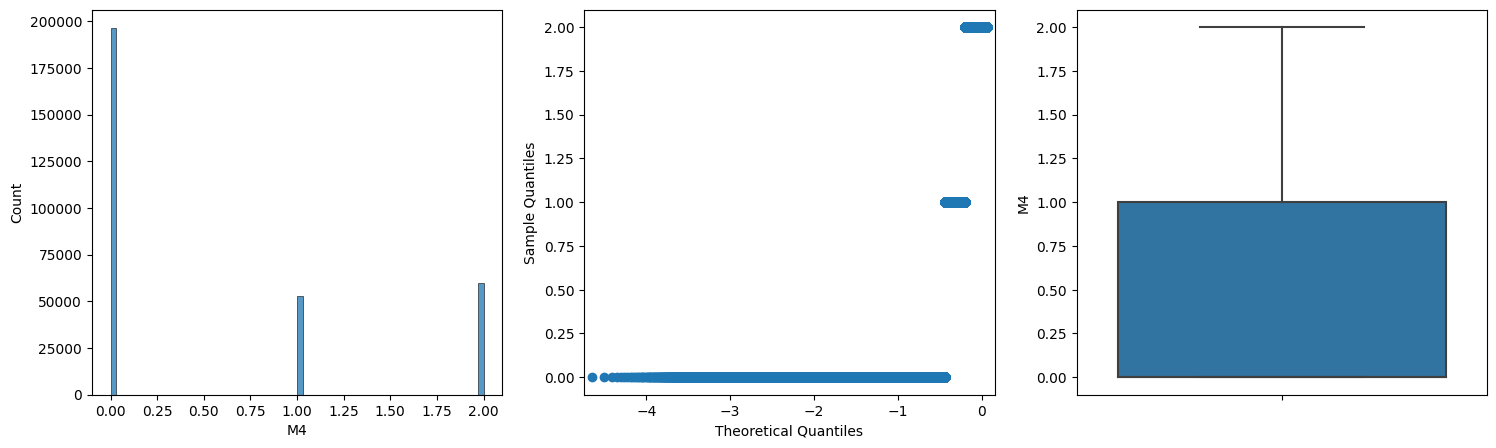

In [77]:
#encode M4 with labelencoder

temp_df = train_df[['M4','isFraud']].copy()
temp_df['M4'] = Encoder_With_Label(data = temp_df, col = 'M4')
Outlier_Detect_IQR(data = temp_df, col='M4')

## M5

In [78]:
train_df['M5'].value_counts(normalize=True)

F    0.551912
T    0.448088
Name: M5, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 1.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is -1.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 1.9480875432491302
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -1.0519124567508698
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


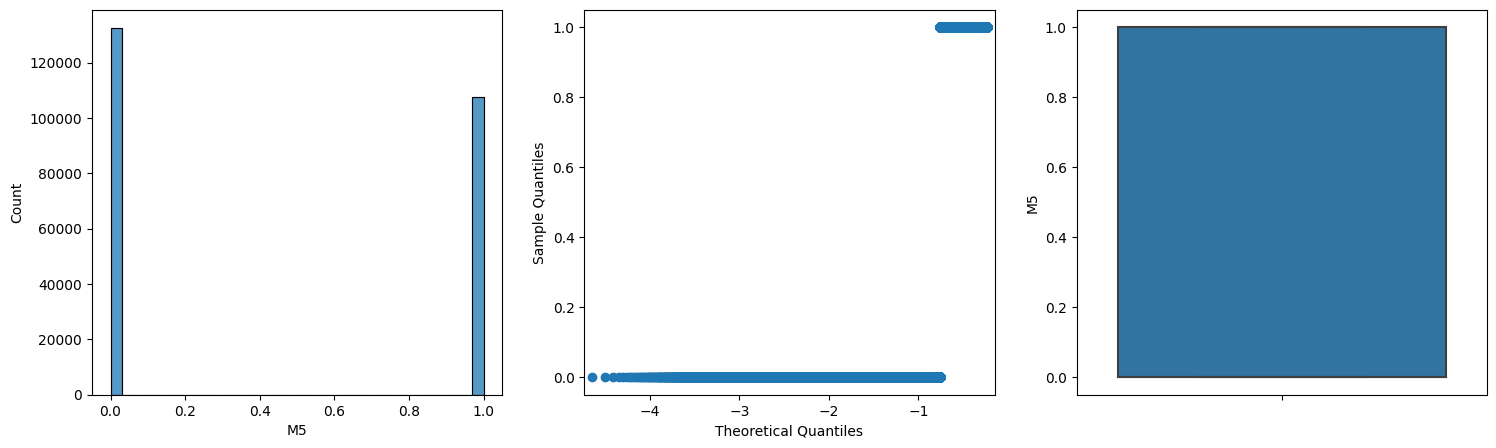

In [79]:
#encode M5 with labelecoder

temp_df = train_df[['M5','isFraud']].copy()
temp_df['M5'] = Encoder_With_Label(data = temp_df, col = 'M5')
Outlier_Detect_IQR(data = temp_df, col='M5')

## M6

In [80]:
train_df['M6'].value_counts(normalize=True)

F    0.540994
T    0.459006
Name: M6, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 1.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is -1.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 1.9590056538581848
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -1.0409943461418152
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


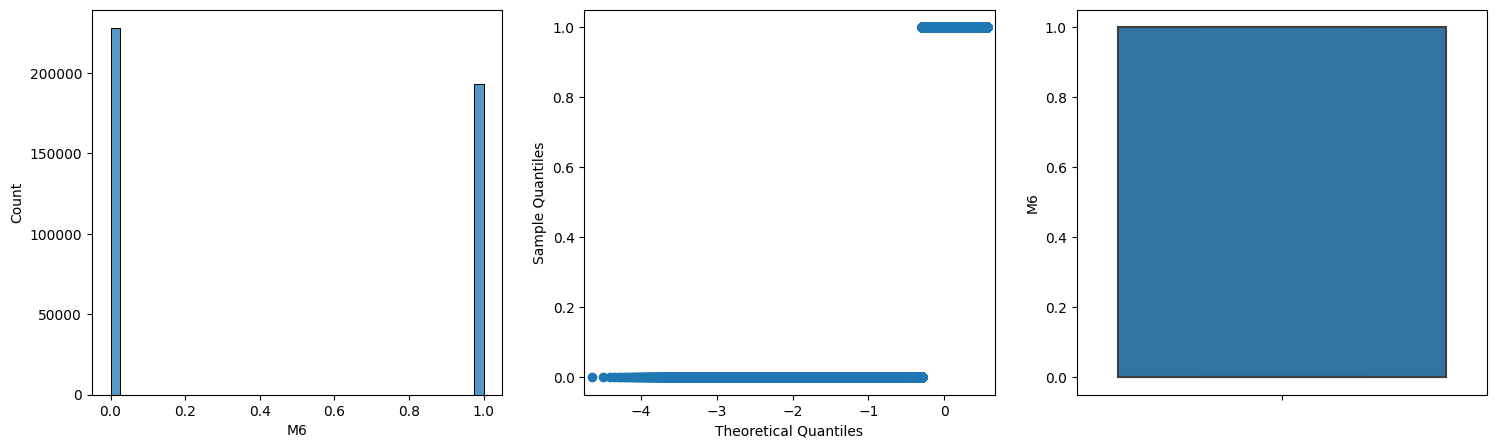

In [81]:
#encode M6 with labelencoder
temp_df = train_df[['M6','isFraud']].copy()
temp_df['M6'] = Encoder_With_Label(data = temp_df, col = 'M6')
Outlier_Detect_IQR(data = temp_df, col='M6')

## M7

In [82]:
train_df['M7'].value_counts(normalize=True)

F    0.865312
T    0.134688
Name: M7, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 0.0
1.2 the potential outliers above 1.5IQR amount is : 32901
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
1.0              32901
dtype: int64
1.4 the lower bound value is 0.0
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 0.1346883624792099
2.2 the potential outliers above 1.5IQR amount is : 32901
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
1.0              32901
dtype: int64
2.4 the lower bound is 0.1346883624792099
2.5 the potential outliers below 1.5IQR amount is : 211374
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              211374
dtype: int6

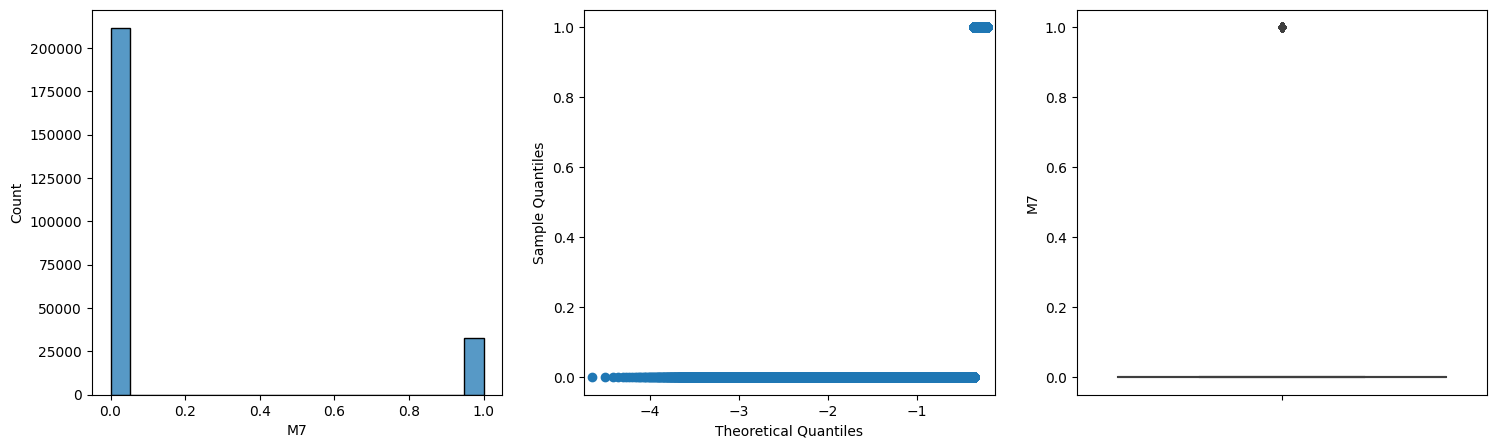

In [83]:
#encode M7 with labelencoder
temp_df = train_df[['M7','isFraud']].copy()
temp_df['M7'] = Encoder_With_Label(data = temp_df, col = 'M7')
Outlier_Detect_IQR(data = temp_df, col='M7')

## M8

In [84]:
train_df['M8'].value_counts(normalize=True)

F    0.635524
T    0.364476
Name: M8, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 1.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is -1.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 1.8644755482673645
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -1.1355244517326355
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


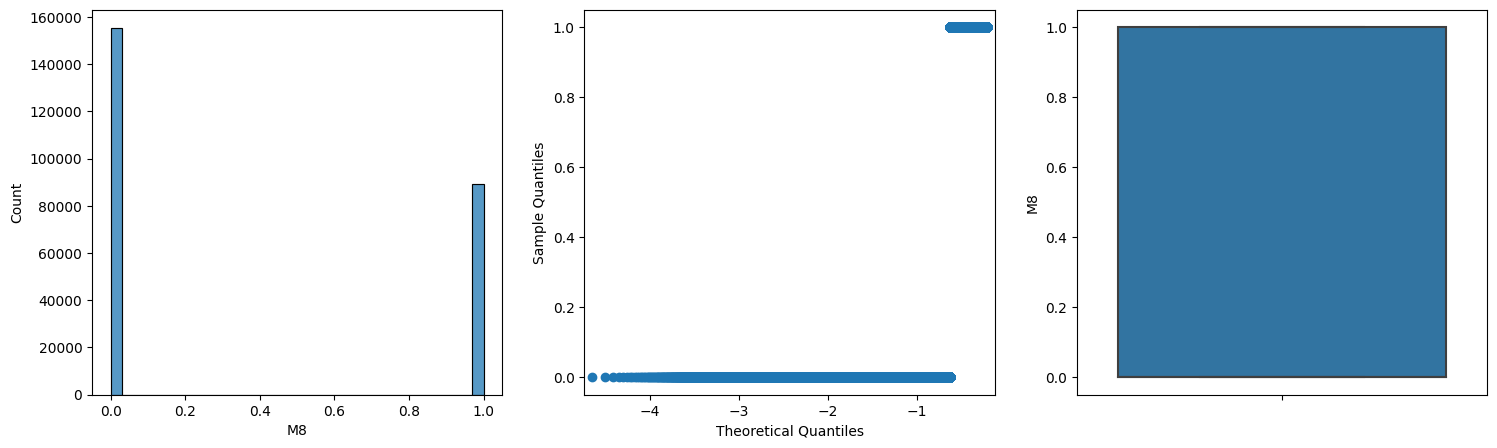

In [85]:
#encode  m8with labelencoder
temp_df = train_df[['M8','isFraud']].copy()
temp_df['M8'] = Encoder_With_Label(data = temp_df, col = 'M8')
Outlier_Detect_IQR(data = temp_df, col='M8')

## M9

In [86]:
train_df['M9'].value_counts(normalize=True)

T    0.841859
F    0.158141
Name: M9, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 1.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 1.0
1.5 the potential outliers below 1.5IQR amount is : 38632
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              38632
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 0.8418588042259216
2.2 the potential outliers above 1.5IQR amount is : 205656
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
1.0              205656
dtype: int64
2.4 the lower bound is 0.8418588042259216
2.5 the potential outliers below 1.5IQR amount is : 38632
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              38632
dtype: int6

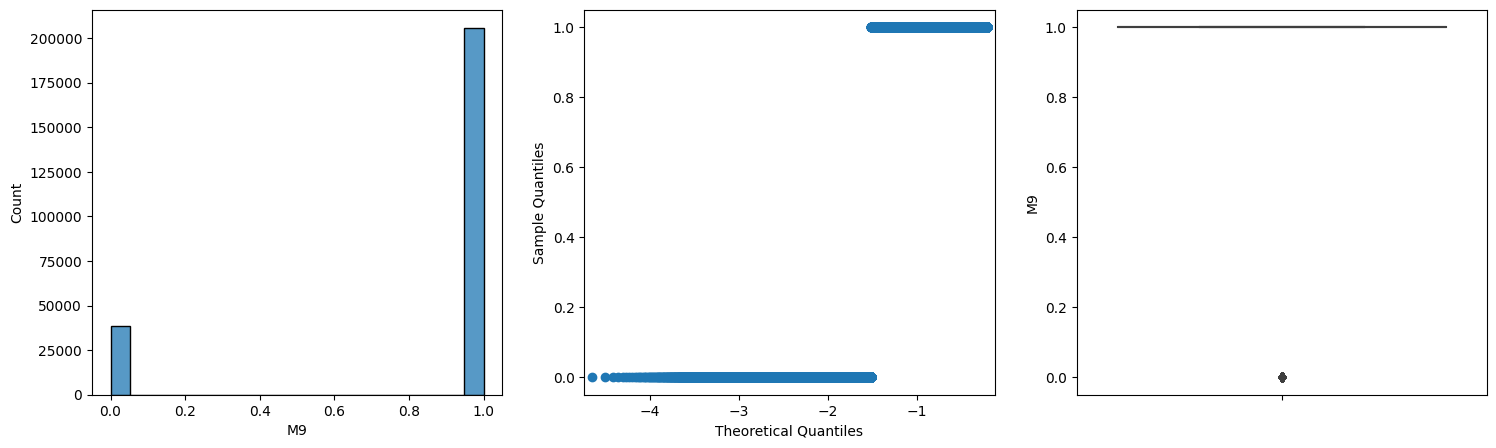

In [87]:
#encode  M9 with labelencoder
temp_df = train_df[['M9','isFraud']].copy()
temp_df['M9'] = Encoder_With_Label(data = temp_df, col = 'M9')
Outlier_Detect_IQR(data = temp_df, col='M9')

## id_12

In [88]:
train_df['id_12'].value_counts(normalize=True)

NotFound    0.85296
Found       0.14704
Name: id_12, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 1.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 1.0
1.5 the potential outliers below 1.5IQR amount is : 21208
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              21208
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 0.8529601693153381
2.2 the potential outliers above 1.5IQR amount is : 123025
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
1.0              123025
dtype: int64
2.4 the lower bound is 0.8529601693153381
2.5 the potential outliers below 1.5IQR amount is : 21208
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              21208
dtype: int6

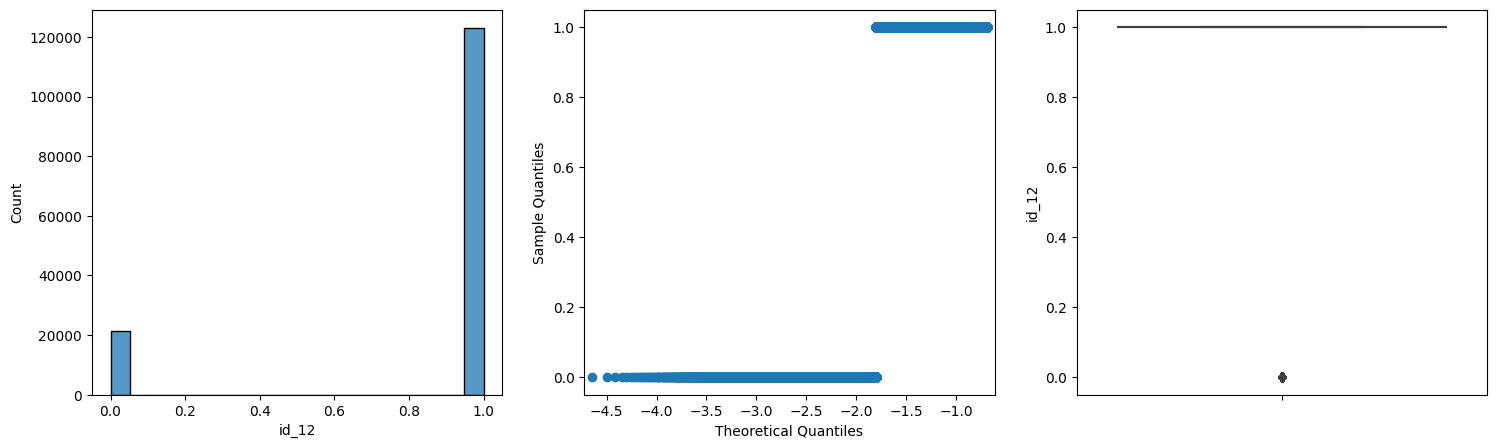

In [89]:
#encoder id_12 with labelencoder 
temp_df = train_df[['id_12','isFraud']].copy()
temp_df['id_12'] = Encoder_With_Label(data = temp_df, col = 'id_12')
Outlier_Detect_IQR(data = temp_df, col='id_12')

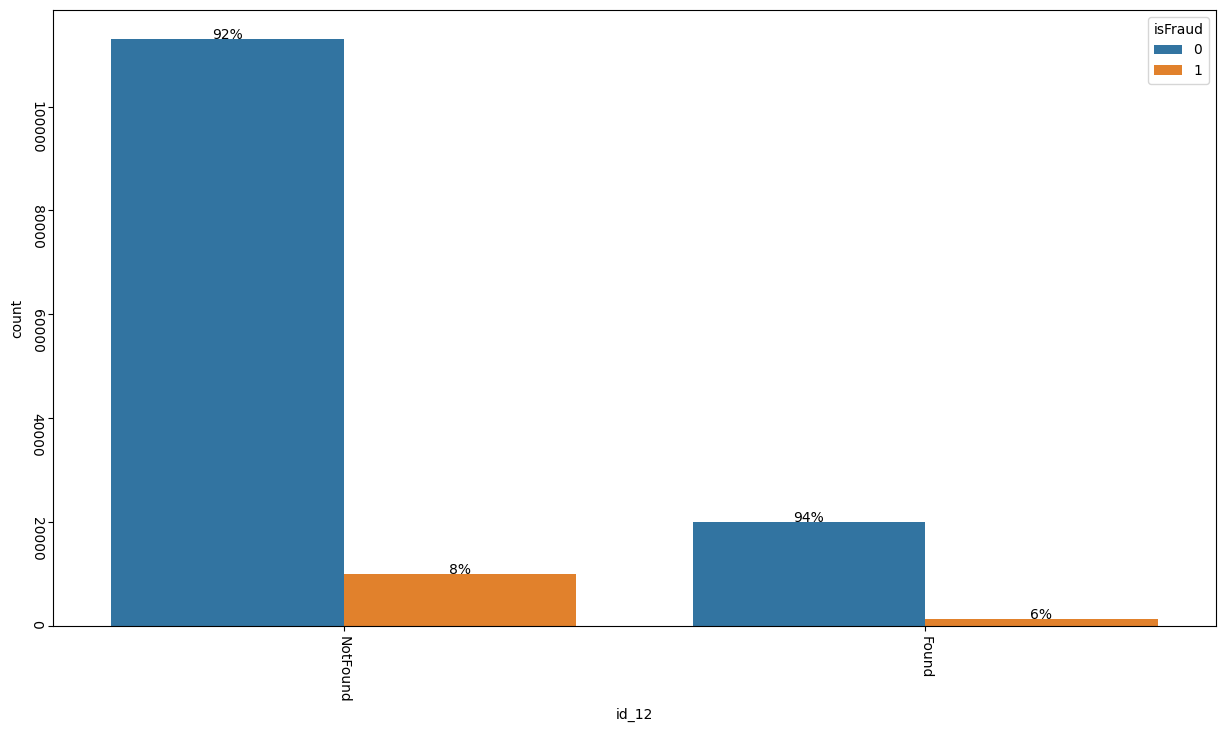

In [90]:
Plot_Cate_Correlation(data = train_df, col_A='id_12', hue_B='isFraud', is_percentage=True)

According to correlation image, we can confirm that id_12 has fraud sample when its value is 0 or 1.

so, we just need to encode id_12

## ID_13

In [91]:
train_df['id_13'].value_counts(normalize=True)

52.0    0.456323
49.0    0.207077
64.0    0.113329
33.0    0.078919
27.0    0.028794
20.0    0.022604
14.0    0.019628
63.0    0.011530
19.0    0.009009
25.0    0.008373
43.0    0.006613
62.0    0.006385
18.0    0.005404
41.0    0.005137
55.0    0.004108
11.0    0.002930
15.0    0.002922
24.0    0.002498
35.0    0.002490
51.0    0.001539
61.0    0.000848
44.0    0.000668
54.0    0.000526
28.0    0.000463
39.0    0.000267
31.0    0.000228
45.0    0.000204
38.0    0.000173
13.0    0.000165
58.0    0.000134
36.0    0.000118
48.0    0.000079
32.0    0.000079
56.0    0.000071
30.0    0.000055
22.0    0.000039
53.0    0.000031
17.0    0.000024
57.0    0.000024
21.0    0.000024
46.0    0.000024
47.0    0.000024
60.0    0.000024
12.0    0.000016
26.0    0.000016
23.0    0.000008
29.0    0.000008
59.0    0.000008
34.0    0.000008
40.0    0.000008
10.0    0.000008
37.0    0.000008
50.0    0.000008
42.0    0.000008
Name: id_13, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 56.5
1.2 the potential outliers above 1.5IQR amount is : 16842
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
64.0             14429
63.0              1468
62.0               813
61.0               108
58.0                17
57.0                 3
60.0                 3
59.0                 1
dtype: int64
1.4 the lower bound value is 47.5
1.5 the potential outliers below 1.5IQR amount is : 25204
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
33.0             10048
27.0              3666
20.0              2878
14.0              2499
19.0              1147
25.0              1066
43.0               842
18.0               688
41.0               654
11.0               373
15.0               372
24.0               318
35.0               317
44.0                85
28.0                59
39.0                34
31.0                29
45.0                26
38.0  

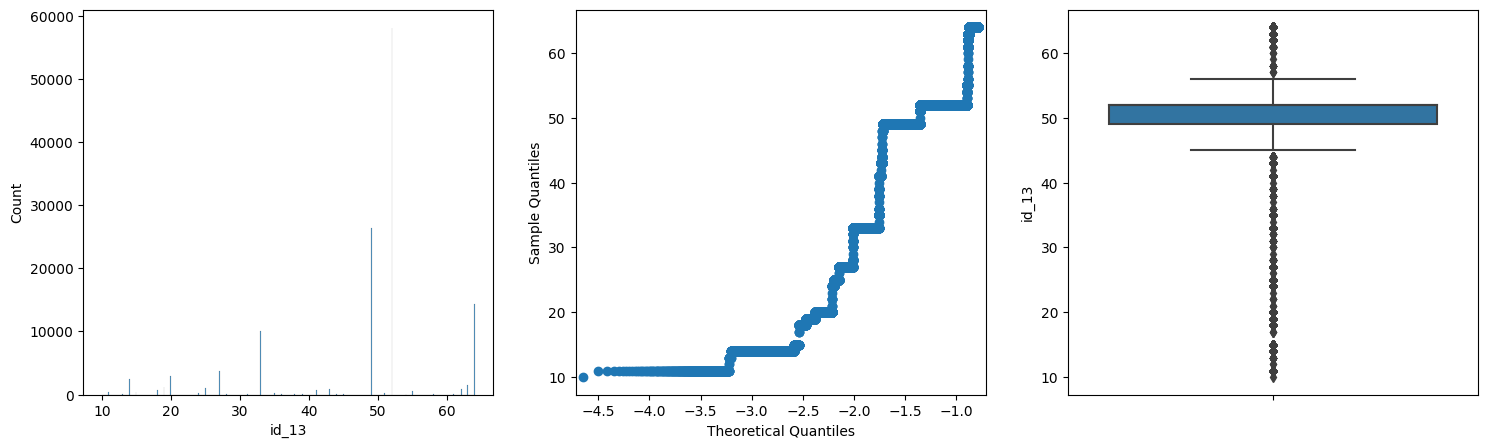

In [92]:
Outlier_Detect_IQR(data = train_df, col='id_13')

In [93]:
#diseretize outliers into other value 9999
train_df['id_13'] = Outliers_Handle_Discretization(data = train_df, col='id_13',method = 'median', value=9999)

## id_14

In [94]:
train_df['id_14'].value_counts(normalize=True)

-300.0    0.551209
-360.0    0.208148
-480.0    0.161049
-420.0    0.056744
-600.0    0.006222
 60.0     0.004610
 0.0      0.002399
-240.0    0.001986
-180.0    0.001574
-540.0    0.001387
 480.0    0.000999
 540.0    0.000800
 600.0    0.000775
 120.0    0.000512
 180.0    0.000462
 420.0    0.000237
 330.0    0.000212
 270.0    0.000187
 240.0    0.000162
 300.0    0.000150
 720.0    0.000112
-660.0    0.000025
-120.0    0.000012
 360.0    0.000012
-210.0    0.000012
Name: id_14, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is -210.0
1.2 the potential outliers above 1.5IQR amount is : 1058
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
 60.0            369
 0.0             192
-180.0           126
 480.0            80
 540.0            64
 600.0            62
 120.0            41
 180.0            37
 420.0            19
 330.0            17
 270.0            15
 240.0            13
 300.0            12
 720.0             9
-120.0             1
 360.0             1
dtype: int64
1.4 the lower bound value is -390.0
1.5 the potential outliers below 1.5IQR amount is : 18044
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
-480.0           12891
-420.0            4542
-600.0             498
-540.0             111
-660.0               2
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value


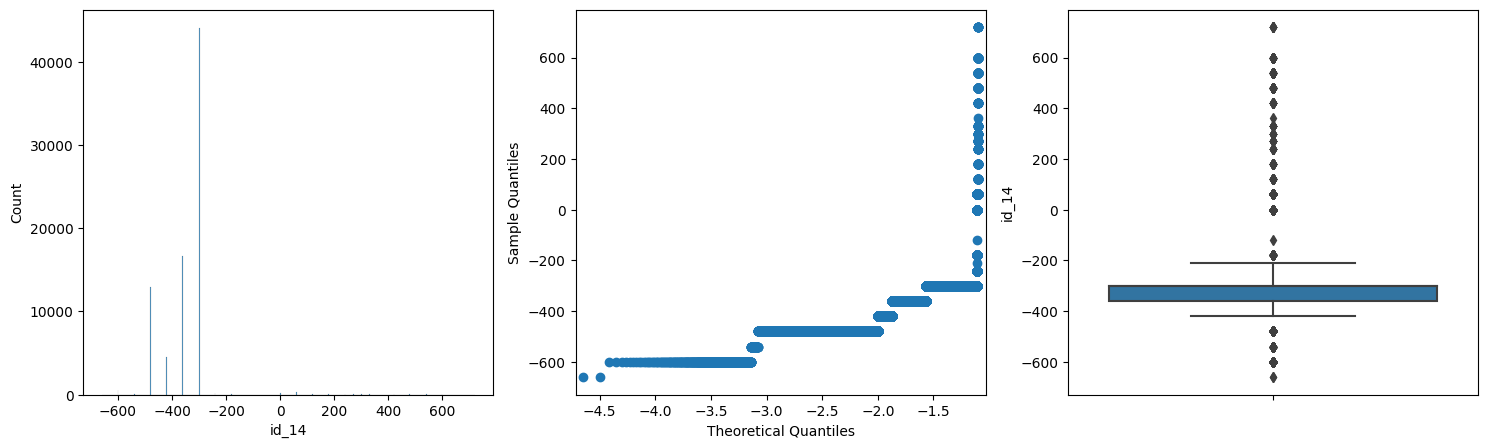

In [95]:
Outlier_Detect_IQR(data = train_df, col = 'id_14')

In [96]:
#discretize outliers into a single value box
train_df['id_14'] = Outliers_Handle_Discretization(data = train_df, col = 'id_14',value=999999)

## id_15

In [97]:
train_df['id_15'].value_counts(normalize=True)

Found      0.480392
New        0.437011
Unknown    0.082597
Name: id_15, dtype: float64

In [98]:
#encoding id_15 firstly
train_df['id_15'] = Encoder_With_Label(data = train_df, col='id_15')

In [99]:
train_df['id_15'].value_counts(normalize=True)

0.0    0.480392
1.0    0.437011
2.0    0.082597
Name: id_15, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 2.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is -0.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 2.1022059321403503
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -0.8977940678596497
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


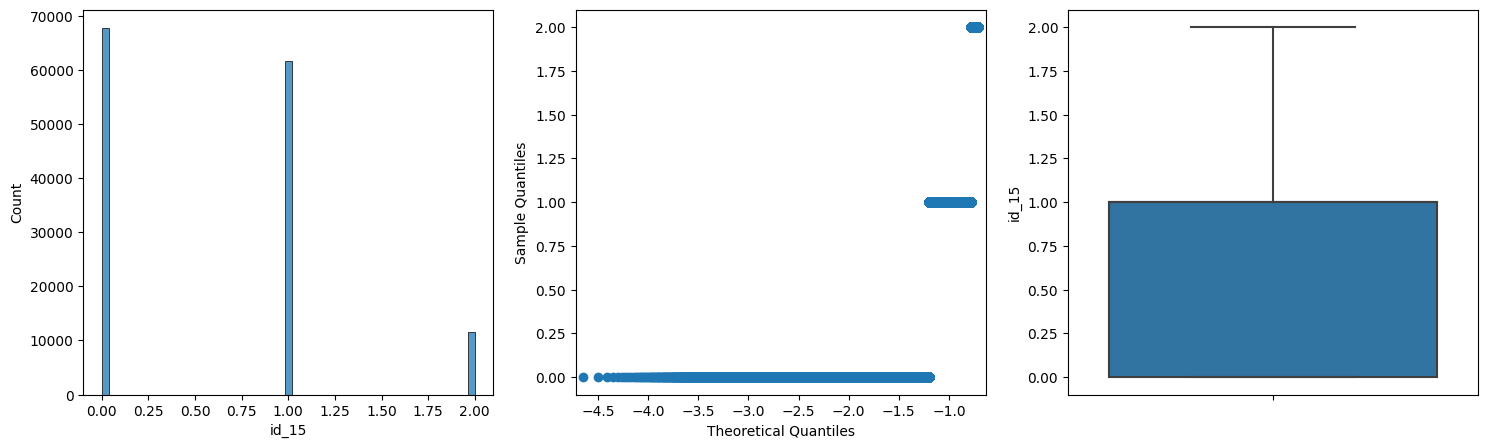

In [100]:
Outlier_Detect_IQR(data = train_df, col='id_15')

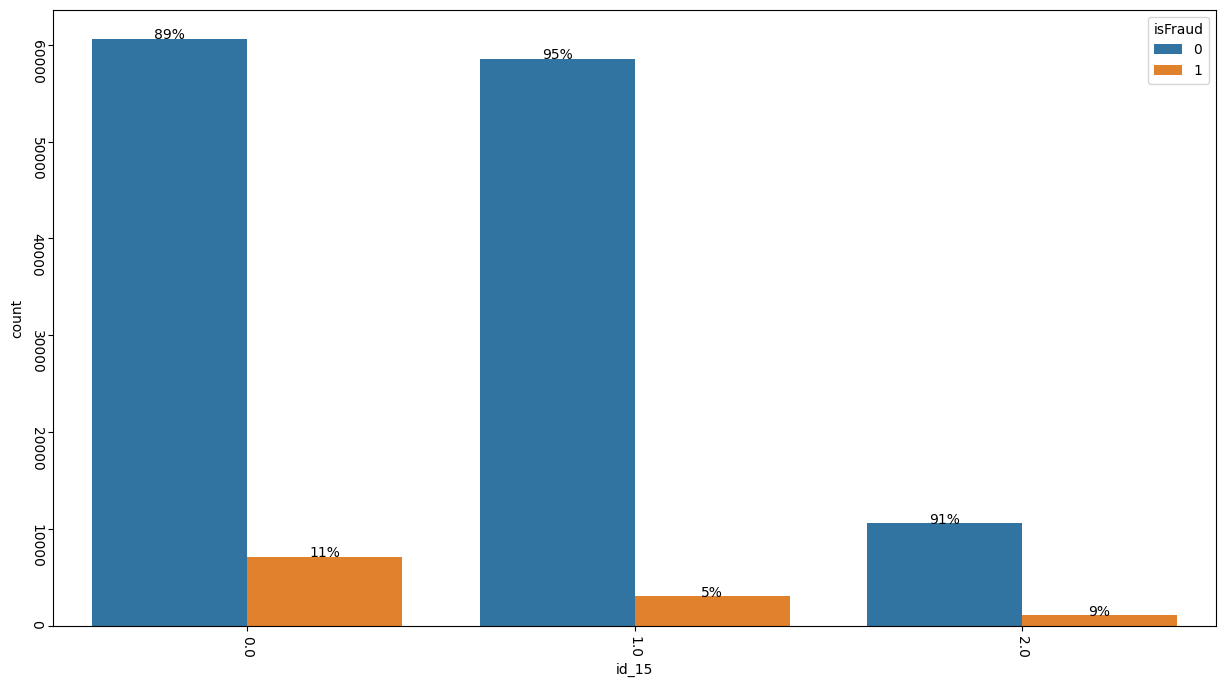

In [101]:
Plot_Cate_Correlation(data = train_df, col_A='id_15', hue_B='isFraud')

Sample has relatively high fraud rate when id_15 is 2. But the percentage of 2 is the minimum in id_15. 

For this reason, we can't process this feature outliers with discretization or other methods

## id_16

In [102]:
train_df['id_16'].value_counts(normalize=True)

Found       0.512788
NotFound    0.487212
Name: id_16, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 1.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is -1.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 1.9872120022773743
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -1.0127879977226257
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


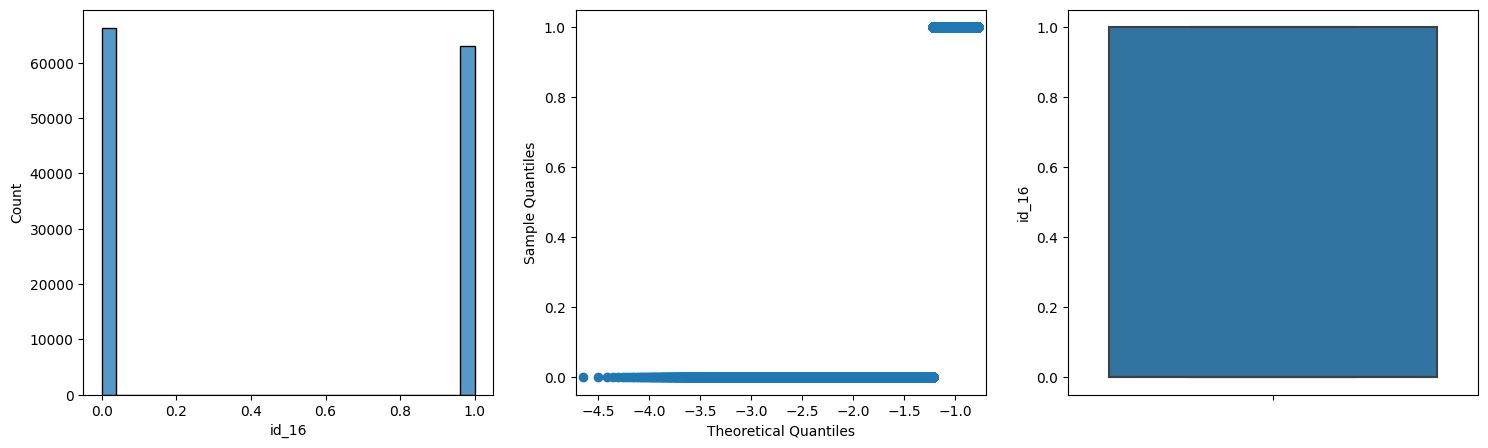

In [103]:
#encoding id_16 firstly
temp_df = train_df[['id_16','isFraud']].copy()
temp_df['id_16'] = Encoder_With_Label(data = temp_df, col = 'id_16')
Outlier_Detect_IQR(data = temp_df, col='id_16')

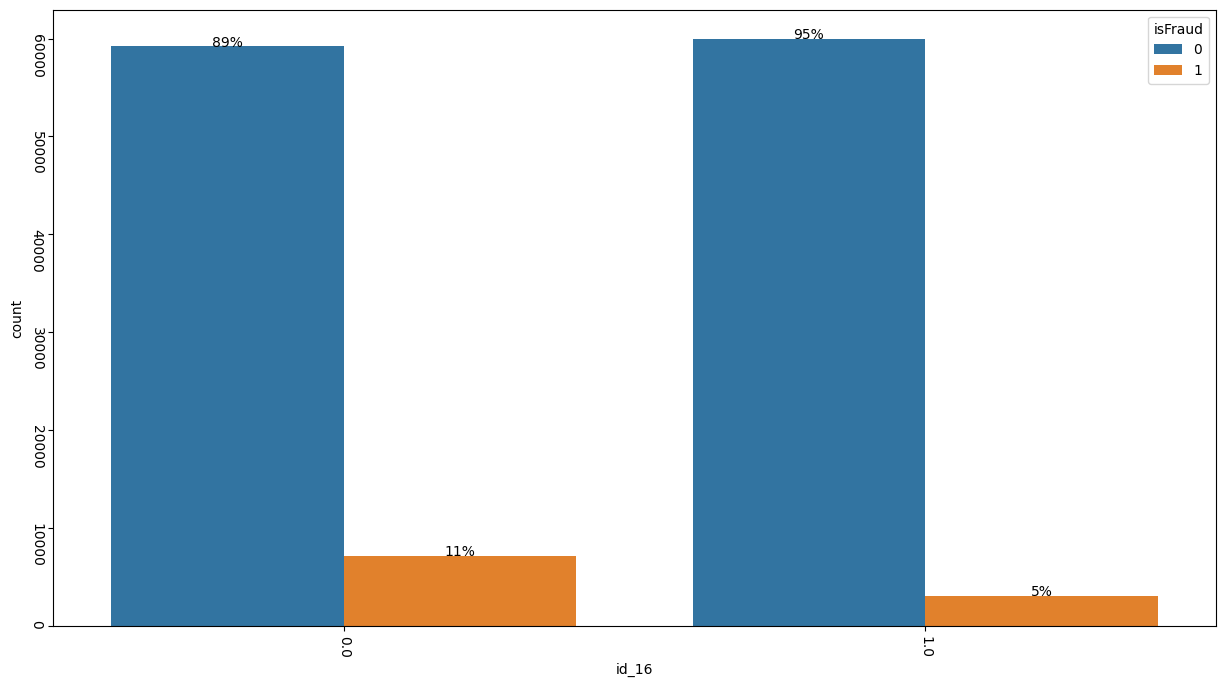

In [104]:
Plot_Cate_Correlation(temp_df, col_A='id_16',hue_B='isFraud')

In [105]:
del temp_df
gc.collect()

13470

This feature is obviously needless to process by outliers methods

## id_17

In [106]:
train_df['id_17'].value_counts(normalize=True)

166.0    0.564193
225.0    0.408757
102.0    0.004944
159.0    0.002526
100.0    0.002411
           ...   
219.0    0.000007
160.0    0.000007
229.0    0.000007
154.0    0.000007
220.0    0.000007
Name: id_17, Length: 104, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 254.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 77.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 277.95137727902187
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is 100.95137727902187
2.5 the potential outliers below 1.5IQR amount is : 336
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
100.0            336
dtype: int64


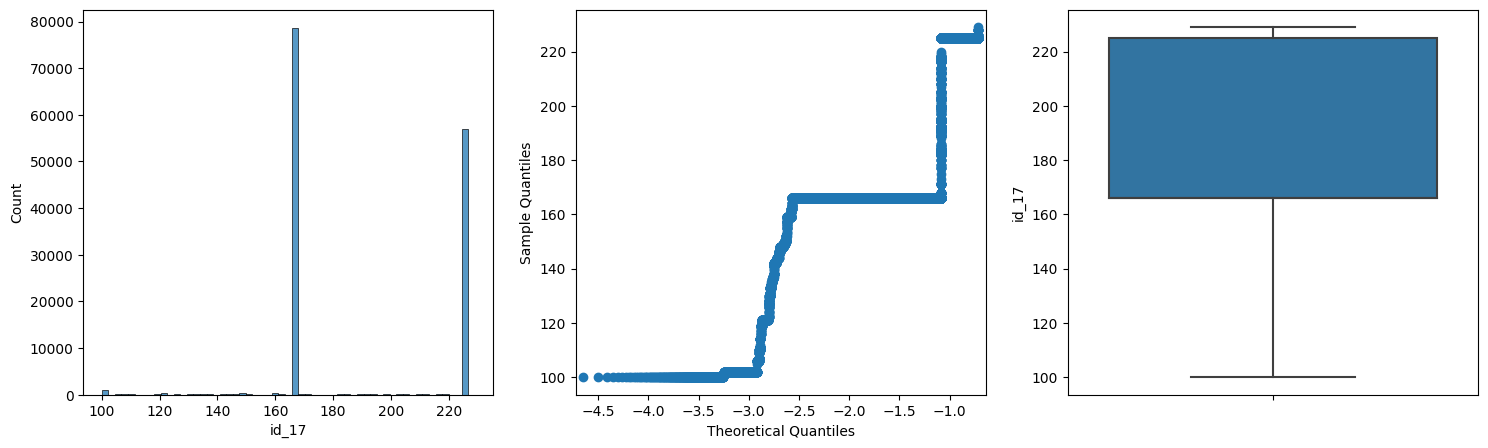

In [107]:
Outlier_Detect_IQR(train_df, col = 'id_17')

This feature may be processed by rare values method

## id_18

In [108]:
train_df['id_18'].value_counts(normalize=True)

15.0    0.565003
13.0    0.297896
12.0    0.103208
18.0    0.014408
20.0    0.007514
17.0    0.005165
26.0    0.001973
21.0    0.001729
24.0    0.001153
11.0    0.000798
27.0    0.000709
29.0    0.000199
23.0    0.000089
14.0    0.000066
16.0    0.000022
28.0    0.000022
25.0    0.000022
10.0    0.000022
Name: id_18, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 18.0
1.2 the potential outliers above 1.5IQR amount is : 605
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
20.0             339
26.0              89
21.0              78
24.0              52
27.0              32
29.0               9
23.0               4
25.0               1
28.0               1
dtype: int64
1.4 the lower bound value is 12.0
1.5 the potential outliers below 1.5IQR amount is : 37
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
11.0             36
10.0              1
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 17.23733735286946
2.2 the potential outliers above 1.5IQR amount is : 1255
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
18.0             650
20.0             339
26.

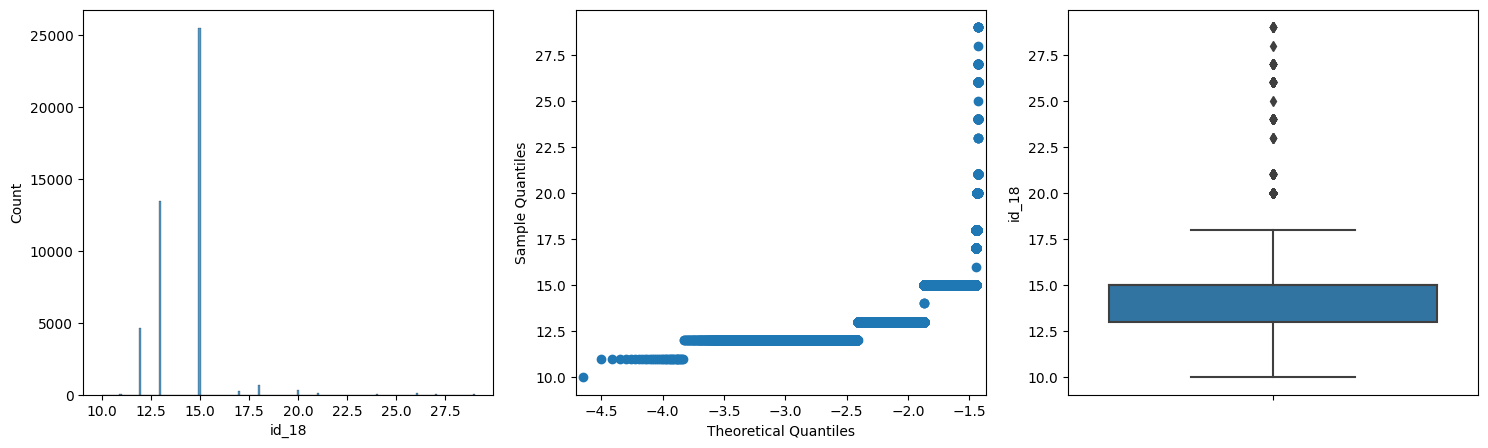

In [109]:
Outlier_Detect_IQR(train_df,col ='id_18')

In [110]:
train_df['id_18'] = Outliers_Handle_Discretization(data = train_df, col = 'id_18', value=999999)

## id_19

In [111]:
train_df['id_19'].value_counts(normalize=True)

266.0    0.142473
410.0    0.081239
427.0    0.063222
529.0    0.058298
312.0    0.044696
           ...   
171.0    0.000007
416.0    0.000007
589.0    0.000007
552.0    0.000007
199.0    0.000007
Name: id_19, Length: 522, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 582.5
1.2 the potential outliers above 1.5IQR amount is : 8319
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
633.0            2702
621.0            2153
607.0             709
630.0             371
585.0             272
                 ... 
619.0               1
584.0               1
604.0               1
668.0               1
589.0               1
Length: 83, dtype: int64
1.4 the lower bound value is 99.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 594.6281743923972
2.2 the potential outliers above 1.5IQR amount is : 7913
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
633.0            2702

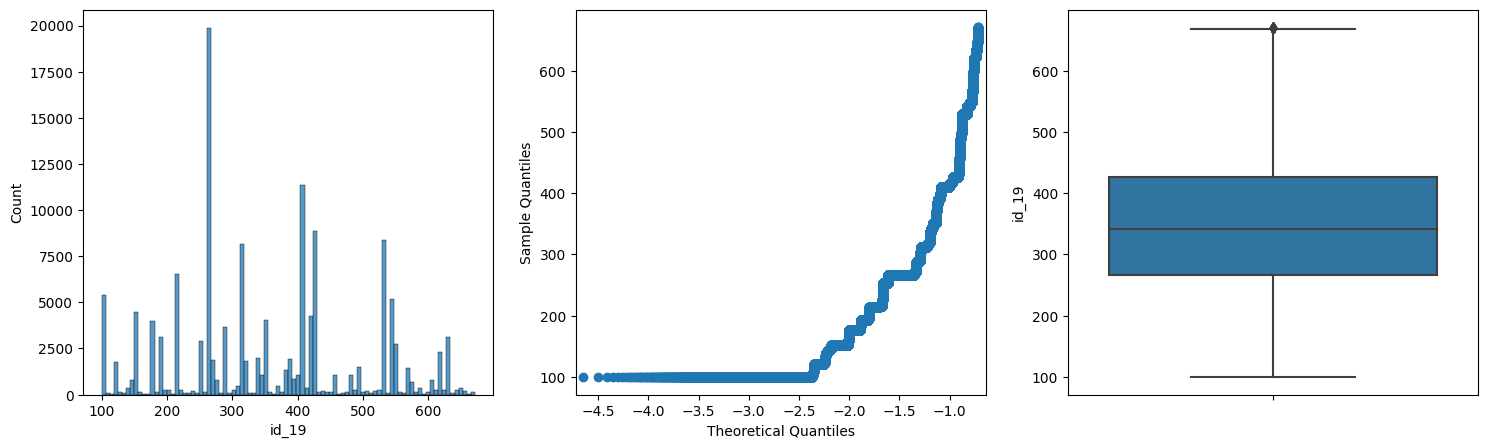

In [112]:
Outlier_Detect_IQR(data = train_df, col = 'id_19')

In [113]:
#discretize id_19  outliers
train_df['id_19'] = Outliers_Handle_Discretization(data = train_df, col='id_19')

## id_20

In [114]:
train_df['id_20'].value_counts(normalize=True)

507.0    0.160210
222.0    0.079455
325.0    0.058401
533.0    0.047472
214.0    0.040672
           ...   
576.0    0.000007
109.0    0.000007
640.0    0.000007
265.0    0.000007
464.0    0.000007
Name: id_20, Length: 394, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 887.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 56.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 819.3826663602875
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -11.617333639712456
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


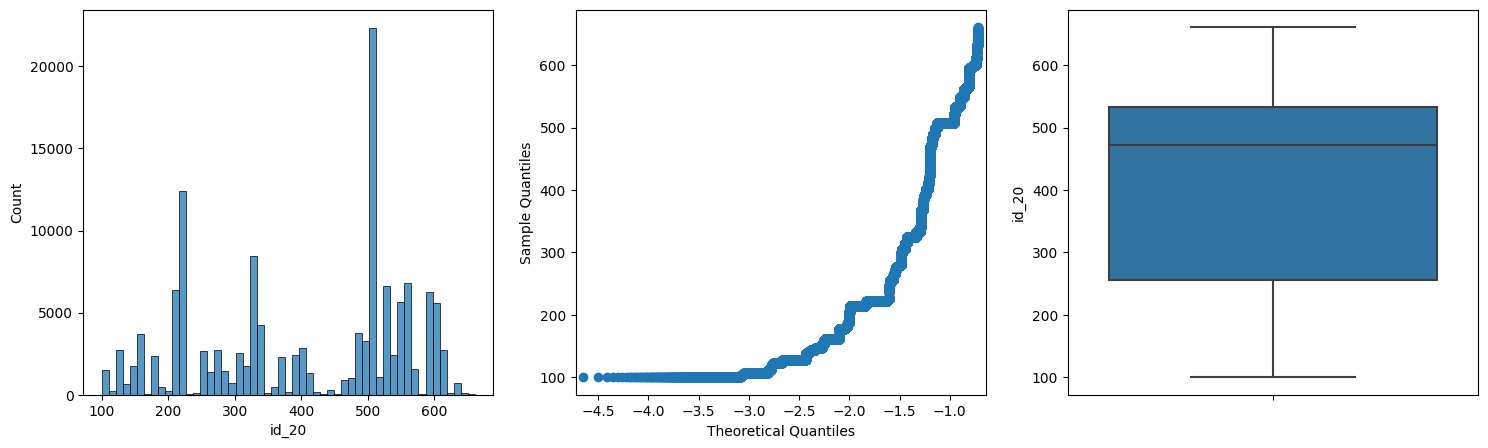

In [115]:
Outlier_Detect_IQR(data = train_df, col = 'id_20')

This feature may be uniform distribution

## id_21

In [116]:
train_df['id_21'].value_counts(normalize=True)

252.0    0.492731
228.0    0.046327
255.0    0.021128
596.0    0.019965
576.0    0.019577
           ...   
544.0    0.000194
715.0    0.000194
473.0    0.000194
190.0    0.000194
840.0    0.000194
Name: id_21, Length: 490, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 603.75
1.2 the potential outliers above 1.5IQR amount is : 821
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
849.0            88
755.0            65
848.0            58
668.0            53
770.0            49
                 ..
730.0             1
729.0             1
637.0             1
638.0             1
735.0             1
Length: 160, dtype: int64
1.4 the lower bound value is -99.75
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 720.0198197325062
2.2 the potential outliers above 1.5IQR amount is : 581
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
849.0            88
755.0            65
8

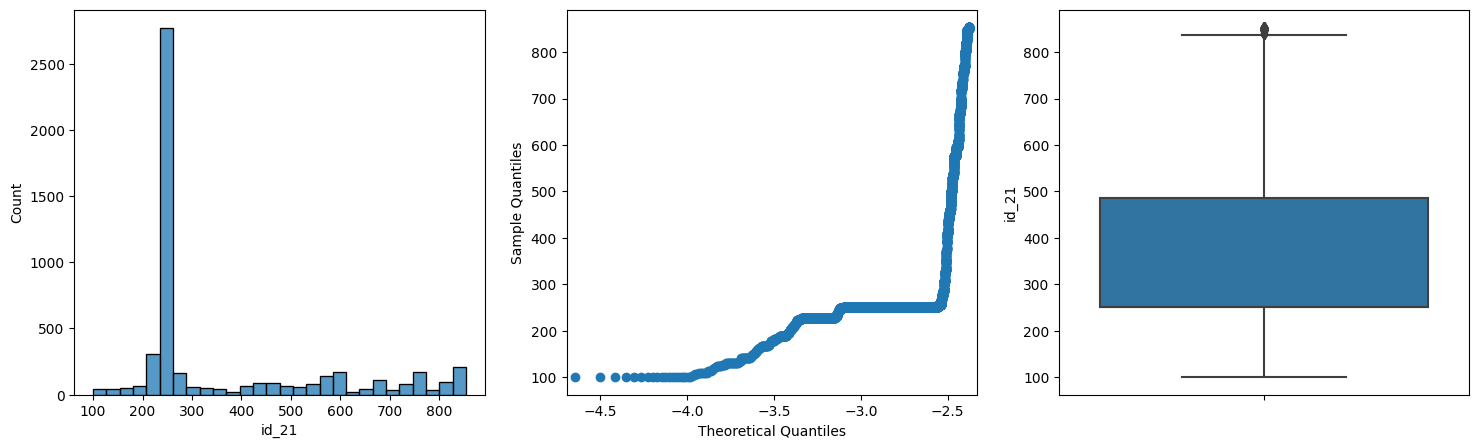

In [117]:
Outlier_Detect_IQR(data = train_df, col = 'id_21')

## id_22

In [118]:
train_df['id_22'].value_counts(normalize=True,dropna=False)

NaN     0.991247
14.0    0.008020
41.0    0.000544
33.0    0.000064
21.0    0.000012
17.0    0.000012
39.0    0.000010
35.0    0.000008
31.0    0.000008
12.0    0.000008
36.0    0.000008
22.0    0.000008
20.0    0.000007
26.0    0.000007
24.0    0.000007
42.0    0.000005
28.0    0.000005
19.0    0.000003
38.0    0.000003
43.0    0.000002
23.0    0.000002
44.0    0.000002
10.0    0.000002
37.0    0.000002
18.0    0.000002
40.0    0.000002
Name: id_22, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 14.0
1.2 the potential outliers above 1.5IQR amount is : 427
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
41.0             321
33.0              38
21.0               7
17.0               7
39.0               6
36.0               5
31.0               5
22.0               5
35.0               5
20.0               4
26.0               4
24.0               4
28.0               3
42.0               3
38.0               2
19.0               2
18.0               1
37.0               1
23.0               1
40.0               1
43.0               1
44.0               1
dtype: int64
1.4 the lower bound value is 14.0
1.5 the potential outliers below 1.5IQR amount is : 6
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
12.0             5
10.0             1
dtype: int64
-------------------------------------------------------------------------------------------------

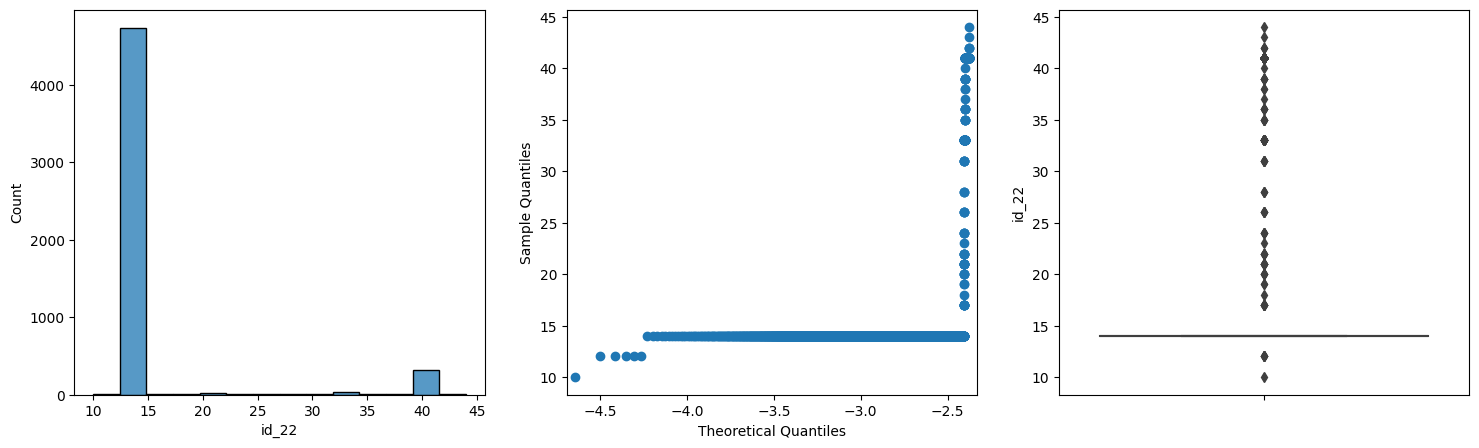

In [119]:
Outlier_Detect_IQR(data = train_df, col = 'id_22')

According to IQR detection  and  percentage of Nan values,  what id_22 is deleted will be a good choice in the process later

## id_23

In [120]:
train_df['id_23'].value_counts(normalize=True)

IP_PROXY:TRANSPARENT    0.674985
IP_PROXY:ANONYMOUS      0.207197
IP_PROXY:HIDDEN         0.117818
Name: id_23, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 3.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 0.5
1.5 the potential outliers below 1.5IQR amount is : 1071
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              1071
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 2.9677886962890625
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -0.0322113037109375
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


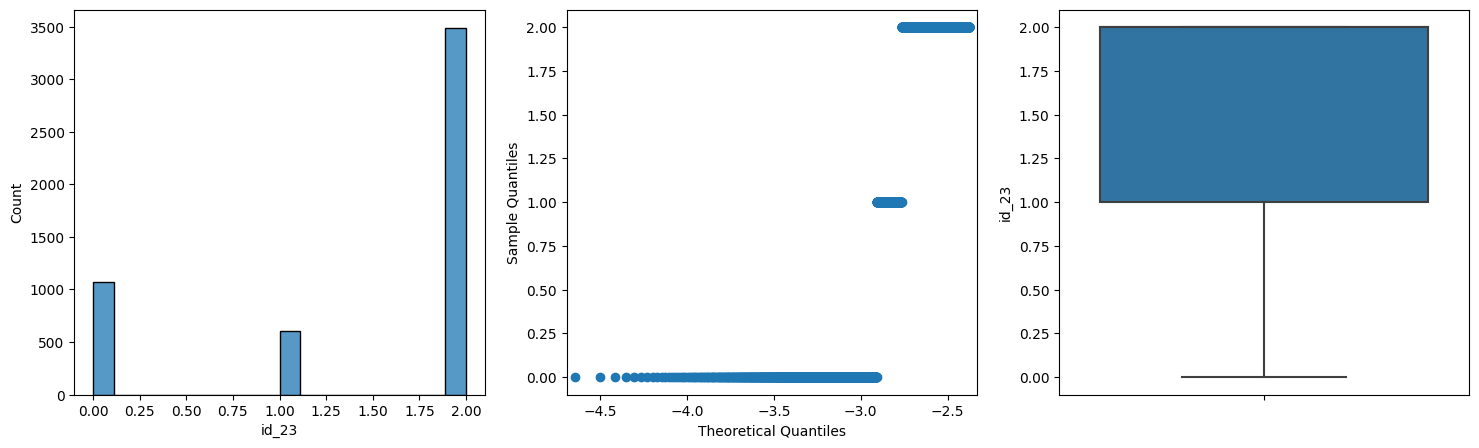

In [121]:
#encoding firstly
temp_df = train_df[['id_23','isFraud']].copy()
temp_df['id_23'] = Encoder_With_Label(data = temp_df, col = 'id_23')
Outlier_Detect_IQR(data = temp_df, col = 'id_23')

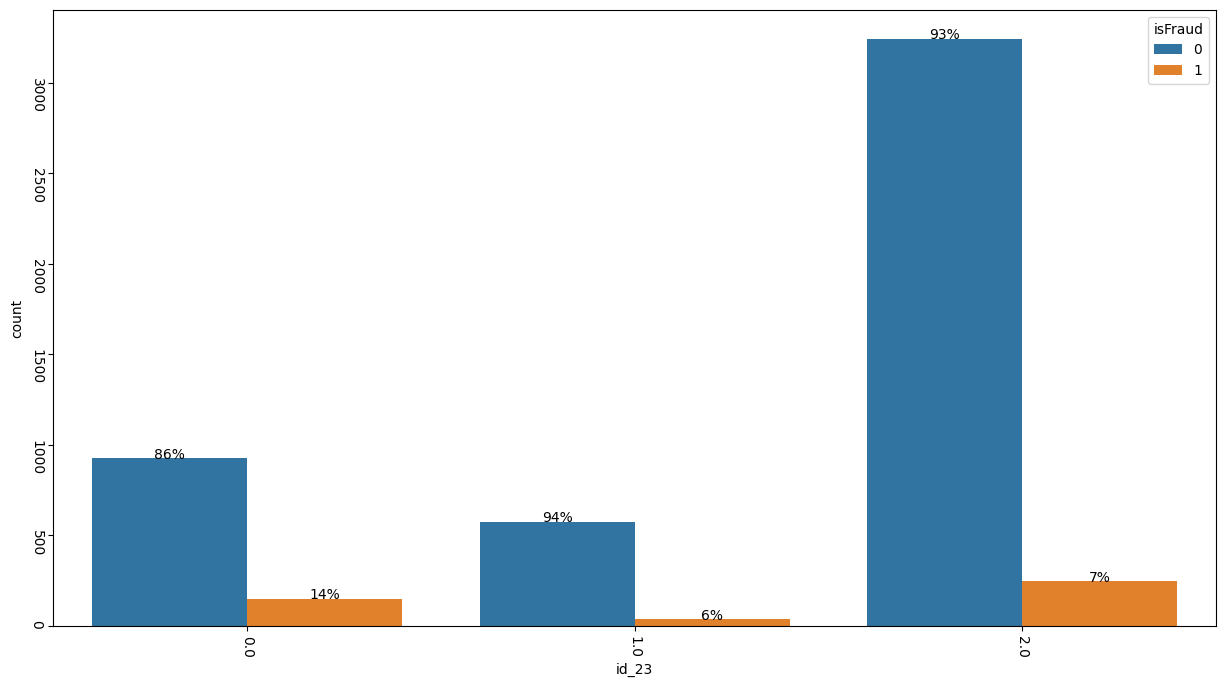

In [122]:
Plot_Cate_Correlation(data = temp_df, col_A= 'id_23', hue_B='isFraud')

do nothing with id_23 but encoding

## id_24

In [123]:
train_df['id_24'].value_counts(normalize=True,dropna=False)

NaN     0.991962
11.0    0.004770
15.0    0.002699
16.0    0.000373
18.0    0.000063
21.0    0.000056
24.0    0.000020
17.0    0.000015
26.0    0.000014
25.0    0.000012
19.0    0.000008
12.0    0.000007
23.0    0.000002
Name: id_24, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 17.0
1.2 the potential outliers above 1.5IQR amount is : 103
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
18.0             37
21.0             33
24.0             12
26.0              8
25.0              7
19.0              5
23.0              1
dtype: int64
1.4 the lower bound value is 5.0
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 18.80092690120076
2.2 the potential outliers above 1.5IQR amount is : 66
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
21.0             33
24.0             12
26.0              8
25.0              7
19.0              5
23.0              1
dtype: int64
2.4 the

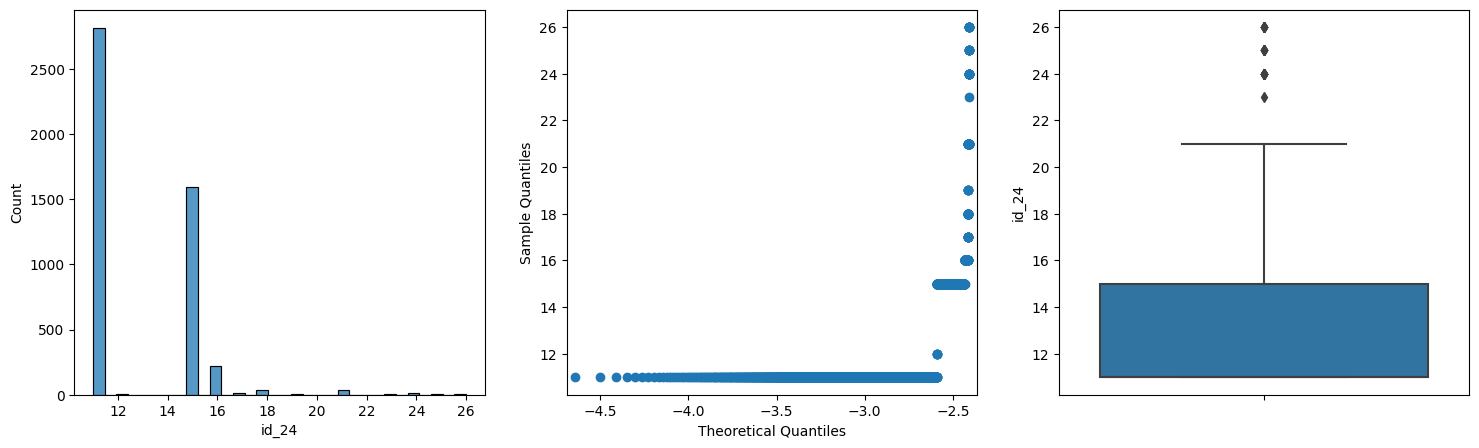

In [124]:
Outlier_Detect_IQR(data = train_df, col ='id_24')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


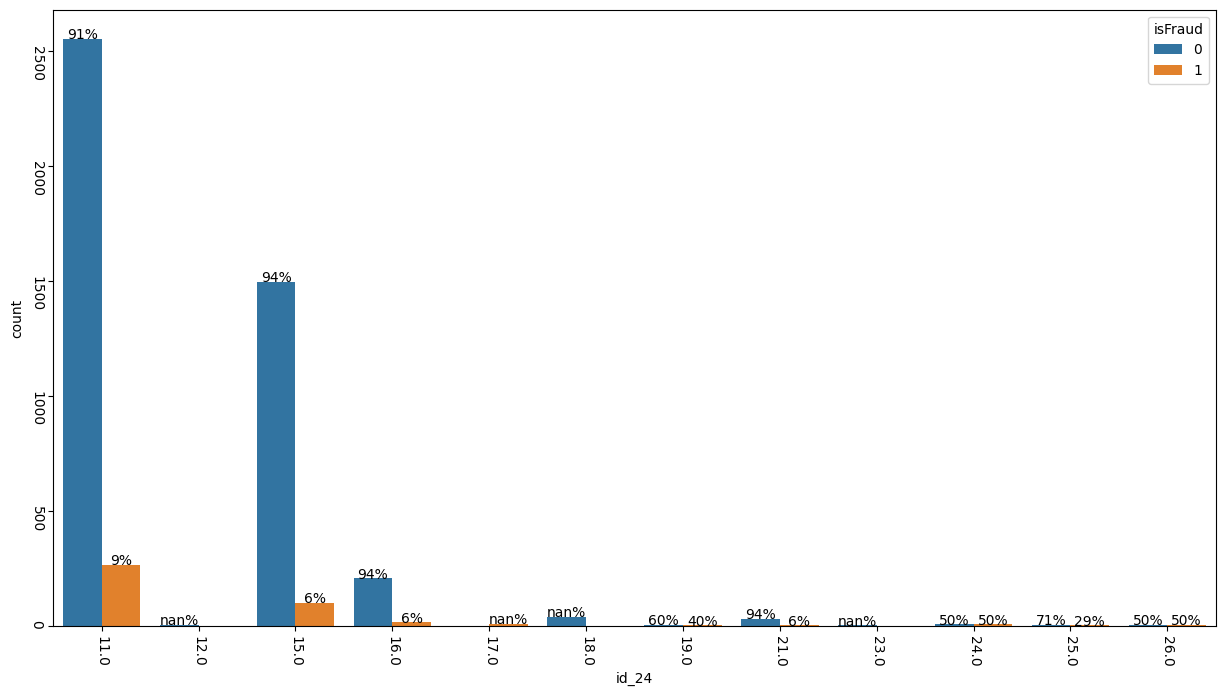

In [125]:
Plot_Cate_Correlation(data =  train_df, col_A='id_24', hue_B='isFraud')

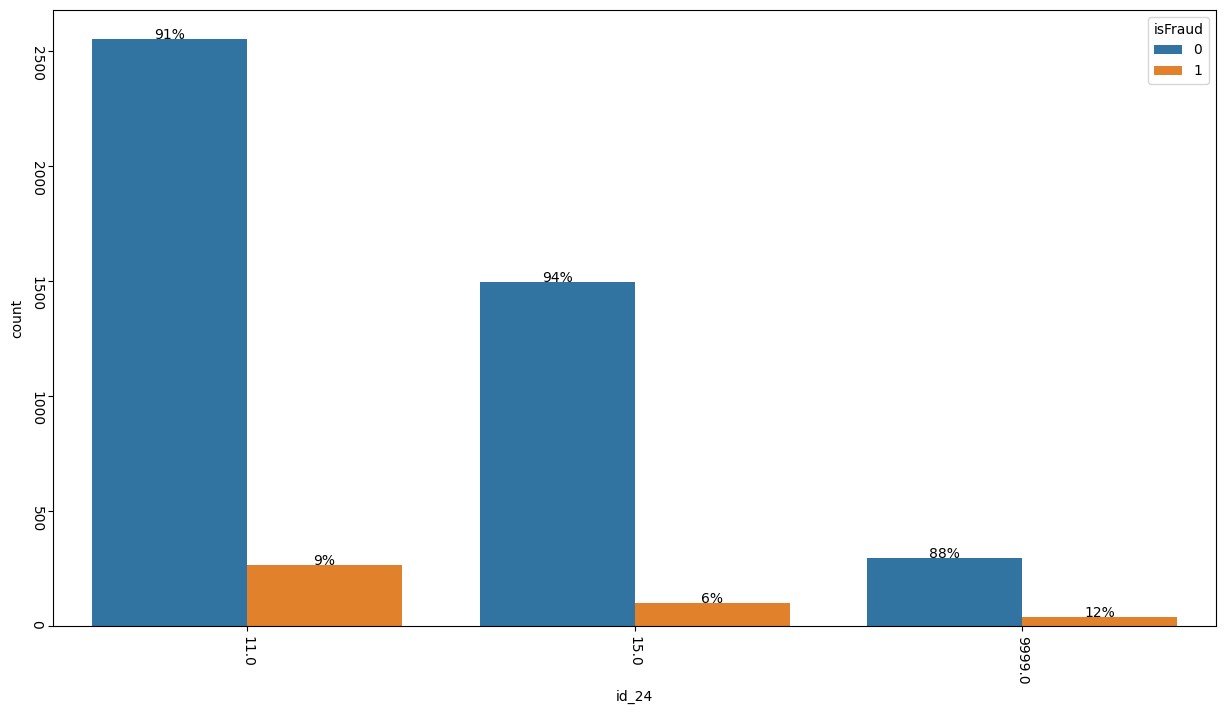

20421

In [126]:
#当把11 喝15之外的值划为一类时isFraud 占比
temp_data = train_df.loc[:,['id_24','isFraud']].copy()
temp_data['id_24'] = temp_data['id_24'].apply(lambda x: x if x ==11 or x == 15 or np.isnan(x) else 9999)
Plot_Cate_Correlation(temp_data,col_A='id_24', hue_B='isFraud')

del temp_data
gc.collect()

In [127]:
train_df['id_24'] = Outliers_Handle_Discretization(data = train_df, col = 'id_24',method='median', value=999999)

## id_25

In [128]:
train_df['id_25'].value_counts(dropna=False, normalize=True)

NaN      0.991310
321.0    0.004223
205.0    0.000510
426.0    0.000400
501.0    0.000174
           ...   
139.0    0.000002
469.0    0.000002
342.0    0.000002
304.0    0.000002
189.0    0.000002
Name: id_25, Length: 342, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 396.0
1.2 the potential outliers above 1.5IQR amount is : 1148
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
426.0            236
501.0            103
524.0             78
442.0             77
509.0             65
                ... 
451.0              1
518.0              1
517.0              1
425.0              1
398.0              1
Length: 110, dtype: int64
1.4 the lower bound value is 246.0
1.5 the potential outliers below 1.5IQR amount is : 915
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
205.0            301
123.0             53
126.0             51
143.0             26
239.0             19
                ... 
165.0              1
189.0              1
187.0              1
166.0              1
175.0              1
Length: 115, dtype: int64
----------------------------------------------------------------------------------------------------
2. 

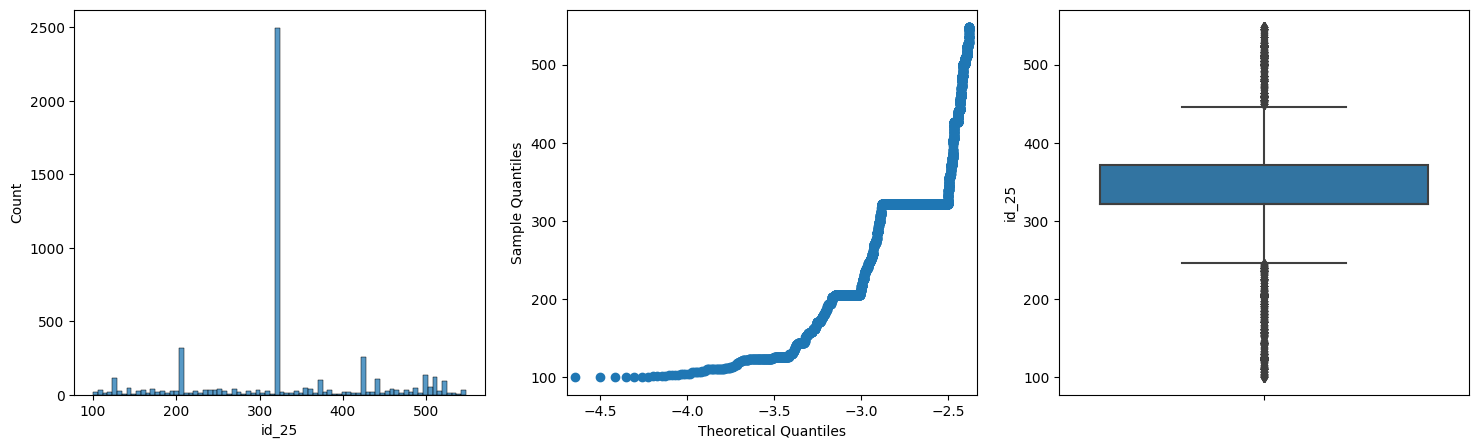

In [129]:
Outlier_Detect_IQR(data = train_df, col = 'id_25')

In [130]:
"单独分箱"
train_df['id_25'] = Outliers_Handle_Discretization(train_df, col = 'id_25',value = 999999)

## id_26

In [131]:
train_df['id_26'].value_counts(normalize=True, dropna= False)

NaN      0.991257
161.0    0.001395
184.0    0.000986
142.0    0.000894
102.0    0.000764
           ...   
214.0    0.000002
127.0    0.000002
101.0    0.000002
200.0    0.000002
198.0    0.000002
Name: id_26, Length: 96, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 224.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 74.0
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 224.0703079604881
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is 74.0703079604881
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


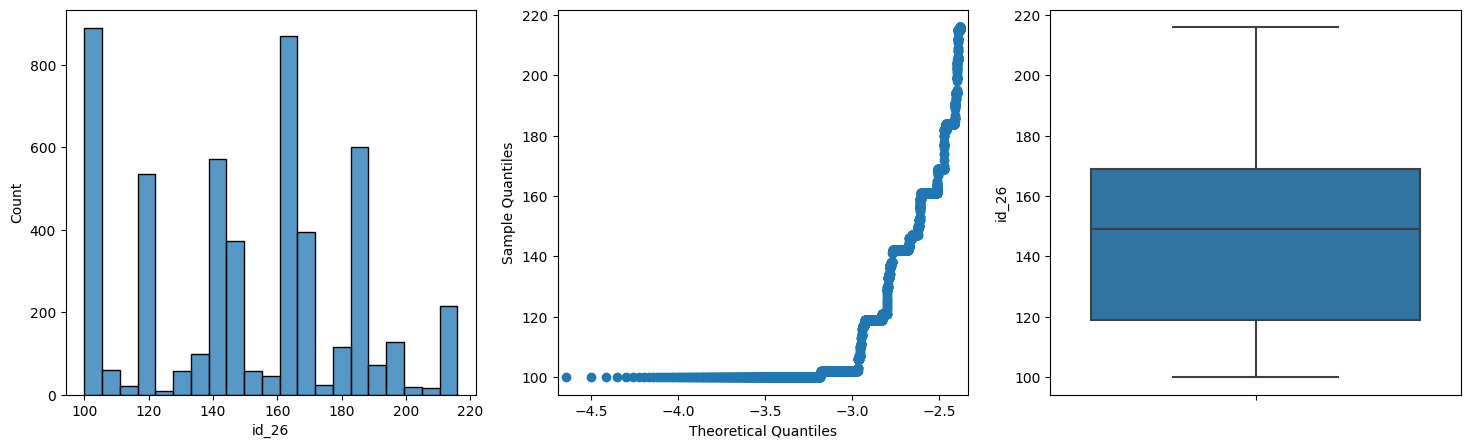

In [132]:
Outlier_Detect_IQR(train_df,col = 'id_26')

## id_27

In [133]:
train_df['id_27'].value_counts(normalize=True, dropna=False)

NaN         0.991247
Found       0.008729
NotFound    0.000024
Name: id_27, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 0.0
1.2 the potential outliers above 1.5IQR amount is : 14
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
1.0              14
dtype: int64
1.4 the lower bound value is 0.0
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 0.0027084541507065296
2.2 the potential outliers above 1.5IQR amount is : 14
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
1.0              14
dtype: int64
2.4 the lower bound is 0.0027084541507065296
2.5 the potential outliers below 1.5IQR amount is : 5155
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              5155
dtype: int64


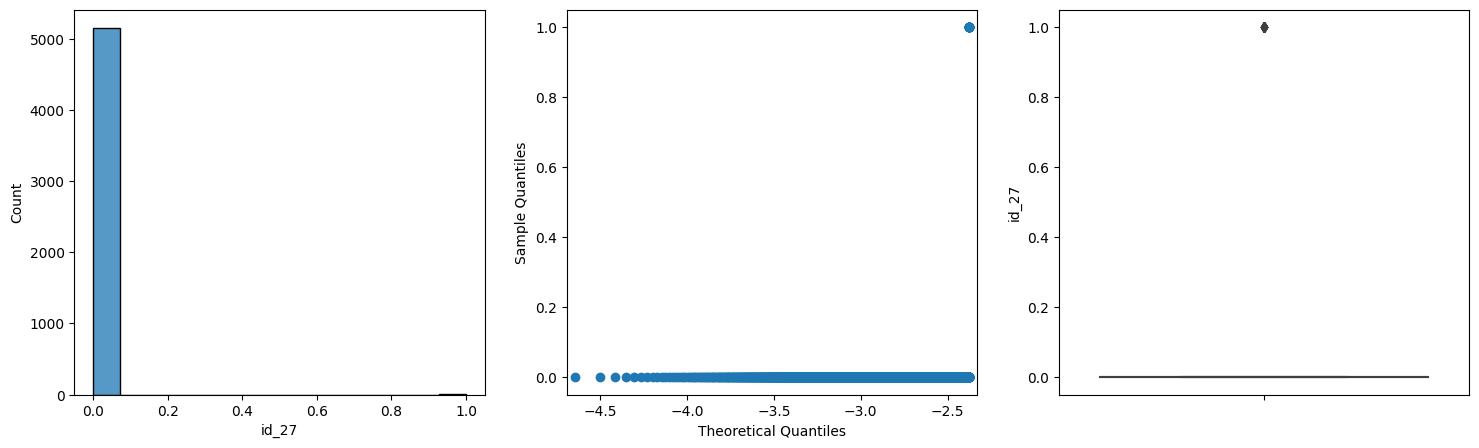

9277

In [134]:
temp_df = train_df[['id_27','isFraud']].copy()
temp_df['id_27'] = Encoder_With_Label(train_df, col = 'id_27')
Outlier_Detect_IQR(temp_df, col = 'id_27')


del  temp_df
gc.collect()

processing it with rare values methods will be a better choice

## id_28 

In [135]:
train_df['id_28'].value_counts(normalize=True, dropna=True)

Found    0.540737
New      0.459263
Name: id_28, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 1.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is -1.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 1.9592631459236145
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -1.0407368540763855
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


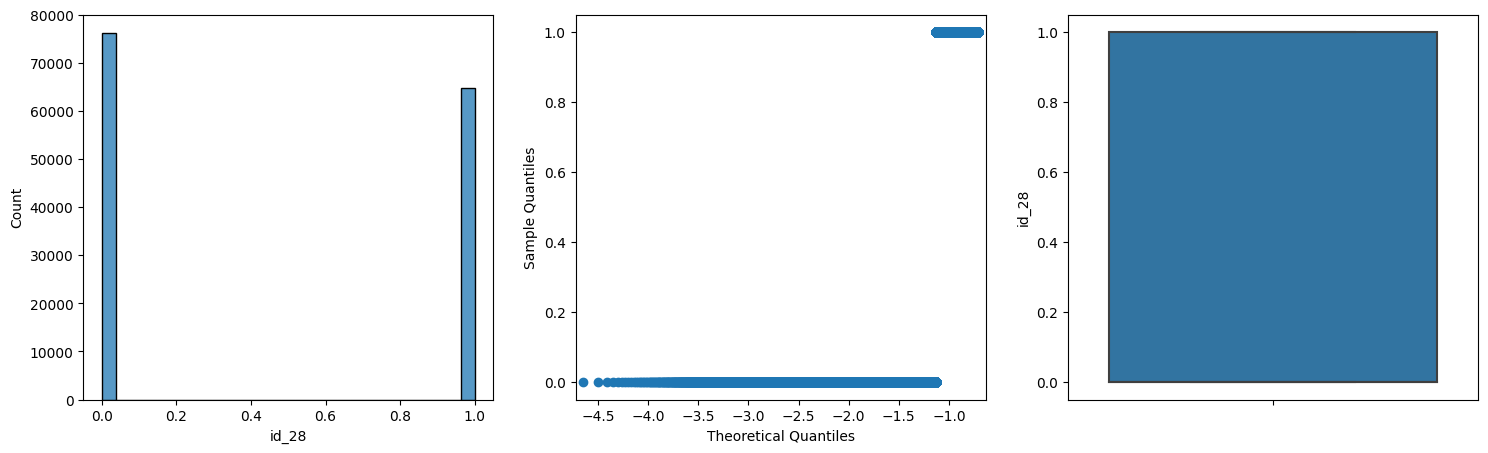

10478

In [136]:
temp_df = train_df[['id_28','isFraud']].copy()
temp_df['id_28'] = Encoder_With_Label(temp_df, col ='id_28')
Outlier_Detect_IQR(temp_df, col = 'id_28')

del temp_df
gc.collect()

## id_29

In [137]:
train_df['id_29'].value_counts(normalize=True, dropna=False)

NaN         0.761273
Found       0.126877
NotFound    0.111850
Name: id_29, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 1.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is -1.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 1.9685270190238953
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -1.0314729809761047
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


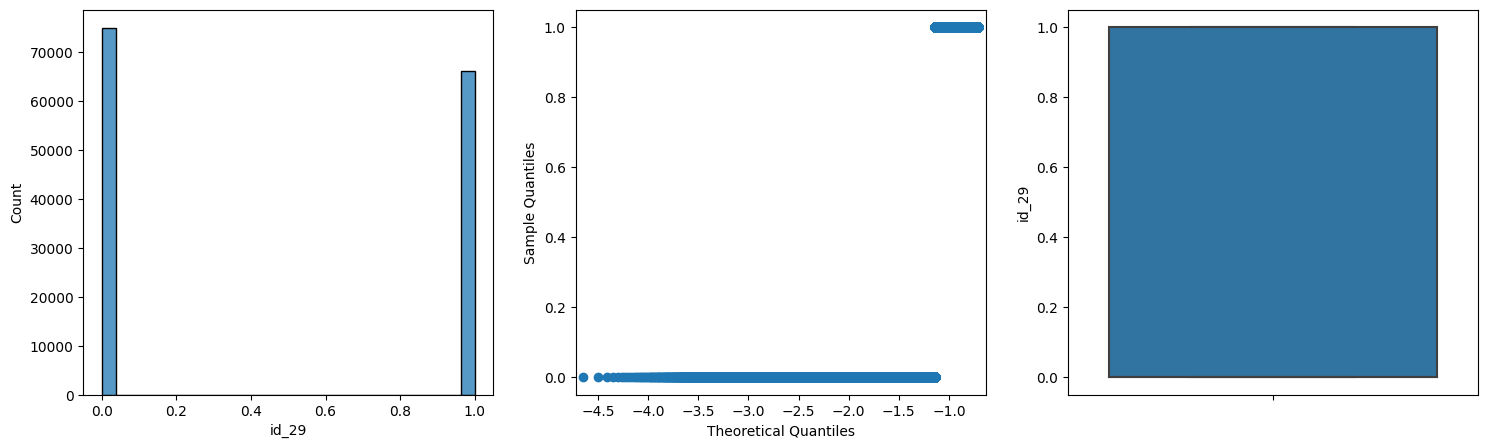

10401

In [138]:
temp_df = train_df[['id_29','isFraud']].copy()
temp_df['id_29'] = Encoder_With_Label(temp_df,col ='id_29')
Outlier_Detect_IQR(temp_df, col ='id_29')

del temp_df
gc.collect()

## id_30

In [139]:
train_df['id_30'].value_counts(normalize=True, dropna=False)

NaN                 0.868654
Windows 10          0.035823
Windows 7           0.022200
iOS 11.2.1          0.006303
iOS 11.1.2          0.006264
                      ...   
func                0.000017
iOS 11.4.0          0.000008
Mac OS X 10_13_5    0.000007
Windows             0.000005
iOS 11.4.1          0.000002
Name: id_30, Length: 76, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 67.5
1.2 the potential outliers above 1.5IQR amount is : 4234
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
69.0             2016
68.0             1647
73.0              414
70.0              136
75.0               15
71.0                5
72.0                1
dtype: int64
1.4 the lower bound value is 16.5
1.5 the potential outliers below 1.5IQR amount is : 8295
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
7.0              2871
12.0             1136
0.0              1079
8.0               630
6.0               566
4.0               350
10.0              343
13.0              303
16.0              218
15.0              200
11.0              192
14.0              135
5.0                80
1.0                63
3.0                55
2.0                41
9.0                33
dtype: int64
-----------------------------------------------------------------

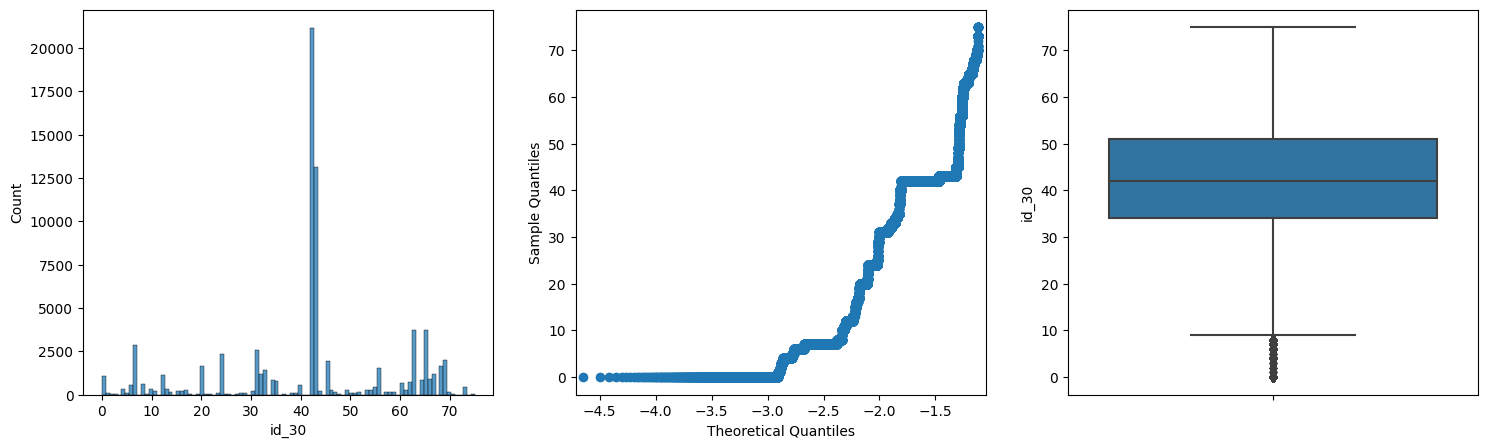

14823

In [140]:
temp_df = train_df[['id_30','isFraud']].copy()
temp_df = Encoder_With_Label(temp_df, col='id_30')
Outlier_Detect_IQR(temp_df, col = 'id_30')

del temp_df
gc.collect()

for its string value ,we will handle outliers after encoding

## id_31

In [141]:
train_df['id_31'].value_counts(normalize=True, dropna=False)

NaN                        0.762451
chrome 63.0                0.037254
mobile safari 11.0         0.022730
mobile safari generic      0.019430
ie 11.0 for desktop        0.015291
                             ...   
LG/K-200                   0.000002
chromium                   0.000002
iron                       0.000002
M4Tel/M4                   0.000002
chrome 67.0 for android    0.000002
Name: id_31, Length: 131, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 133.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is -19.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 146.71207427978516
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -6.287925720214844
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


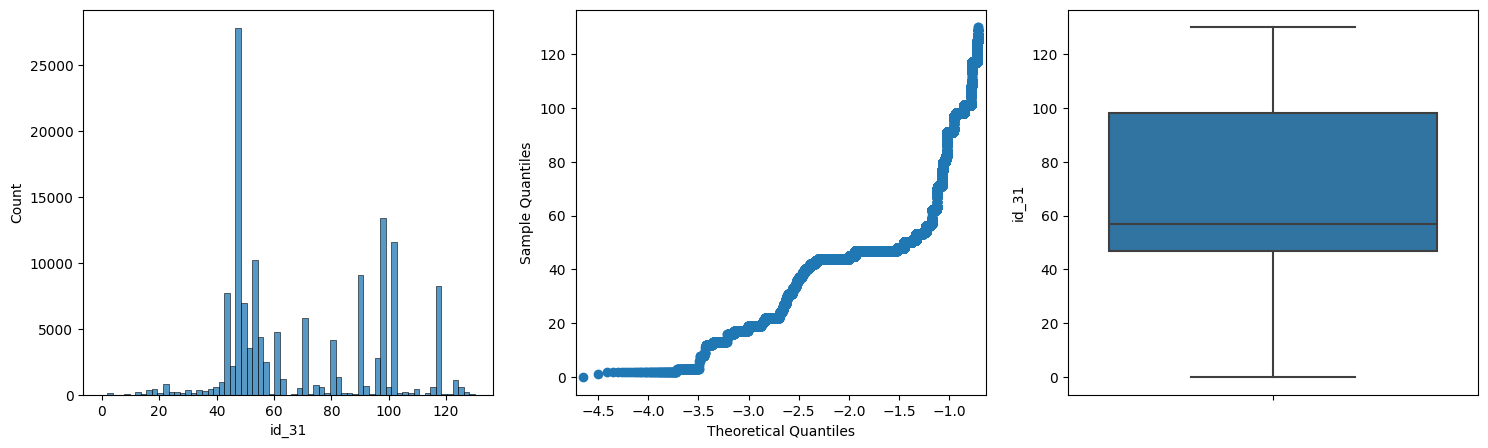

12798

In [142]:
temp_df = train_df[['id_31','isFraud']].copy()
temp_df = Encoder_With_Label(temp_df, col='id_31')
Outlier_Detect_IQR(temp_df, col = 'id_31')

del temp_df
gc.collect()

nothing is to be done

## id_32

In [143]:
train_df['id_32'].value_counts(normalize=True, dropna=False)

NaN     0.868619
24.0    0.089869
32.0    0.041366
16.0    0.000137
0.0     0.000010
Name: id_32, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 36.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 12.0
1.5 the potential outliers below 1.5IQR amount is : 6
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              6
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 38.50859691181399
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is 14.508596911813989
2.5 the potential outliers below 1.5IQR amount is : 6
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              6
dtype: int64


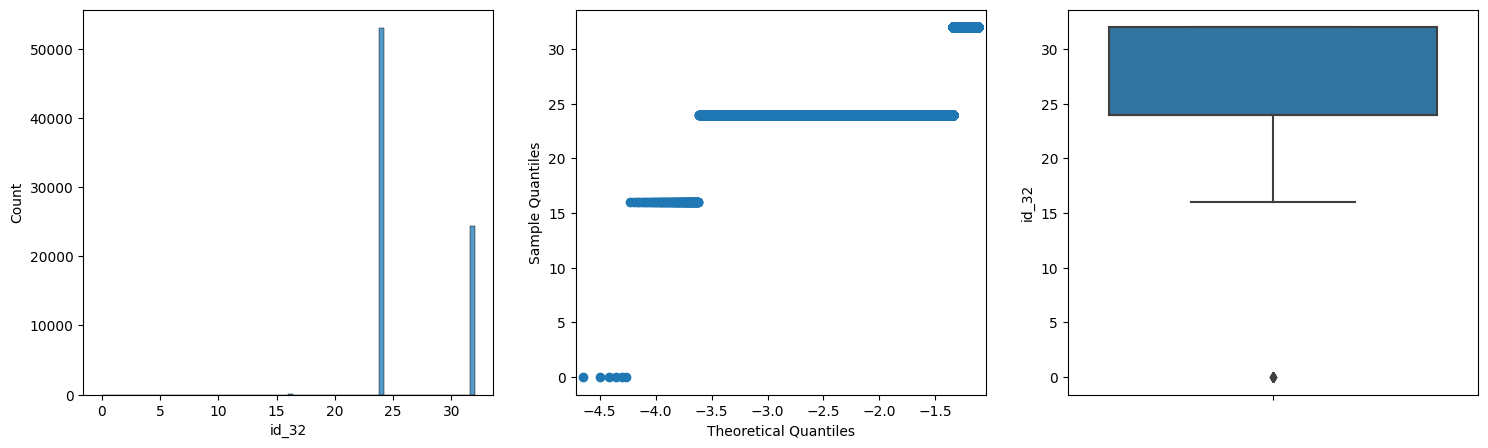

In [144]:
Outlier_Detect_IQR(train_df, col = 'id_32')

## id_33


In [145]:
train_df['id_33'].value_counts(normalize=True, dropna=False)

NaN          0.875895
1920x1080    0.028574
1366x768     0.014571
1334x750     0.010917
2208x1242    0.008297
               ...   
1536x960     0.000002
1232x800     0.000002
1264x924     0.000002
1281x800     0.000002
1280x900     0.000002
Name: id_33, Length: 261, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 265.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is -1.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 244.22582244873047
2.2 the potential outliers above 1.5IQR amount is : 409
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
255.0            250
254.0             64
257.0             58
258.0             12
249.0              8
253.0              5
245.0              3
247.0              2
246.0              1
248.0              1
250.0              1
251.0              1
252.0              1
256.0  

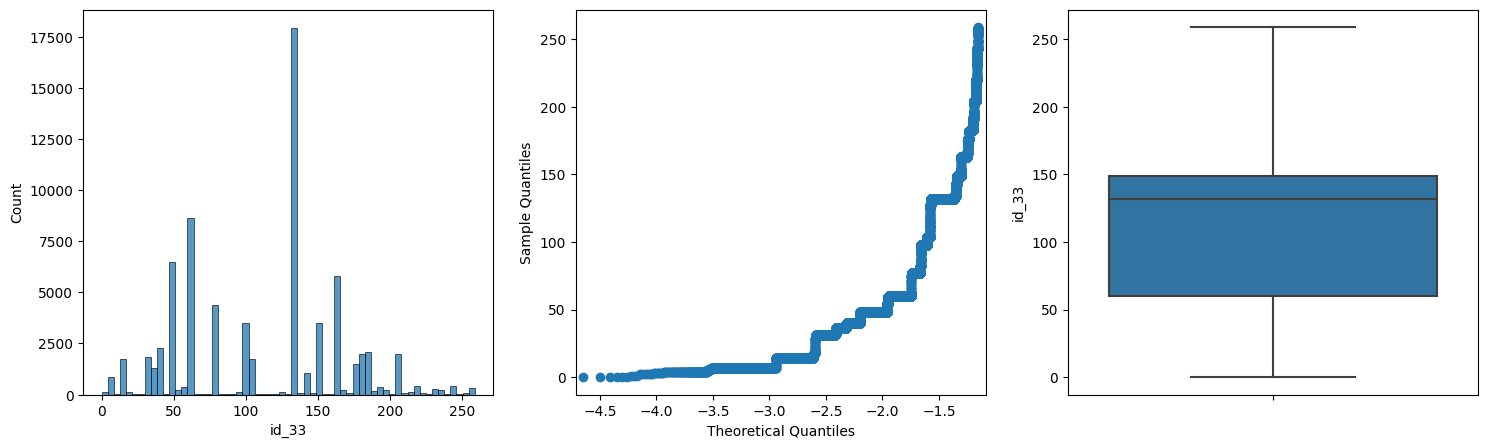

12296

In [146]:
temp_df = train_df[['id_33','isFraud']].copy()
temp_df = Encoder_With_Label(temp_df, col='id_33')
Outlier_Detect_IQR(temp_df, col = 'id_33')

del temp_df
gc.collect()

## id_34

In [147]:
train_df['id_34'].value_counts(normalize=True, dropna=False)

NaN                0.868248
match_status:2     0.101621
match_status:1     0.029424
match_status:0     0.000703
match_status:-1    0.000005
Name: id_34, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 3.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 3.0
1.5 the potential outliers below 1.5IQR amount is : 17794
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
2.0              17376
1.0                415
0.0                  3
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 2.7658891677856445
2.2 the potential outliers above 1.5IQR amount is : 60011
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
3.0              60011
dtype: int64
2.4 the lower bound is 2.7658891677856445
2.5 the potential outliers below 1.5IQR amount is : 17794
2.6 the potential outliers below 1.5IQR values distribution is: 
 outl

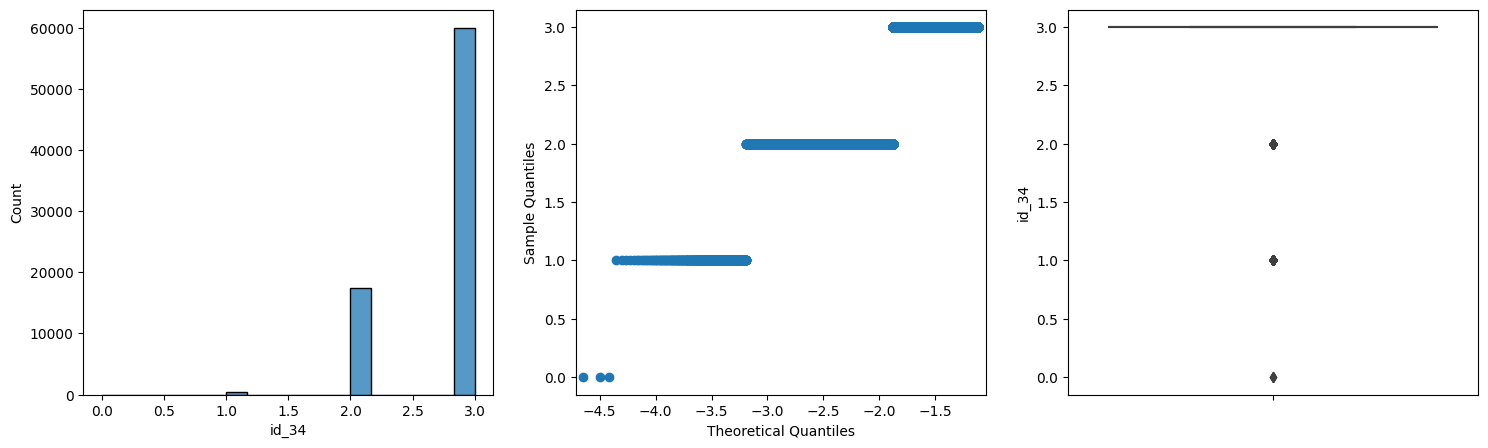

9972

In [148]:
temp_df = train_df[['id_34','isFraud']].copy()
temp_df = Encoder_With_Label(temp_df, col='id_34')
Outlier_Detect_IQR(temp_df, col = 'id_34')

del temp_df
gc.collect()

## ID_35

In [149]:
train_df['id_35'].value_counts(normalize=True, dropna=False)

NaN    0.761261
T      0.131768
F      0.106972
Name: id_35, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 2.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is -0.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 2.051931083202362
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -0.9480689167976379
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


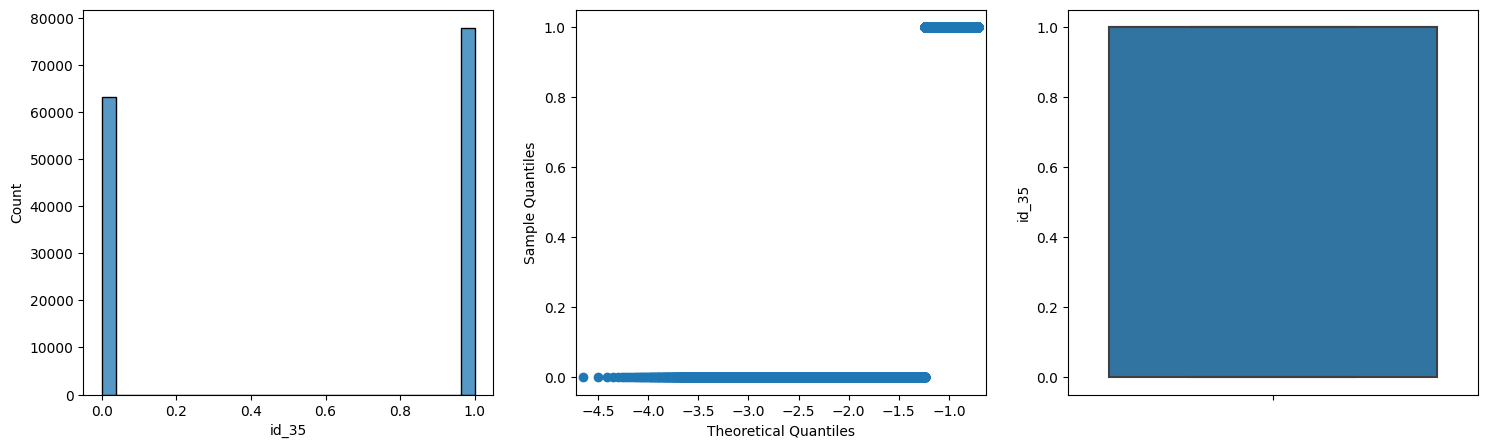

10478

In [150]:
temp_df = train_df[['id_35','isFraud']].copy()
temp_df = Encoder_With_Label(temp_df, col='id_35')
Outlier_Detect_IQR(temp_df, col = 'id_35')

del temp_df
gc.collect()

## id_36

In [151]:
train_df['id_36'].value_counts(normalize=True, dropna=False)

NaN    0.761261
F      0.227023
T      0.011716
Name: id_36, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 0.0
1.2 the potential outliers above 1.5IQR amount is : 6919
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
1.0              6919
dtype: int64
1.4 the lower bound value is 0.0
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 0.0490761436522007
2.2 the potential outliers above 1.5IQR amount is : 6919
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
1.0              6919
dtype: int64
2.4 the lower bound is 0.0490761436522007
2.5 the potential outliers below 1.5IQR amount is : 134066
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              134066
dtype: int64


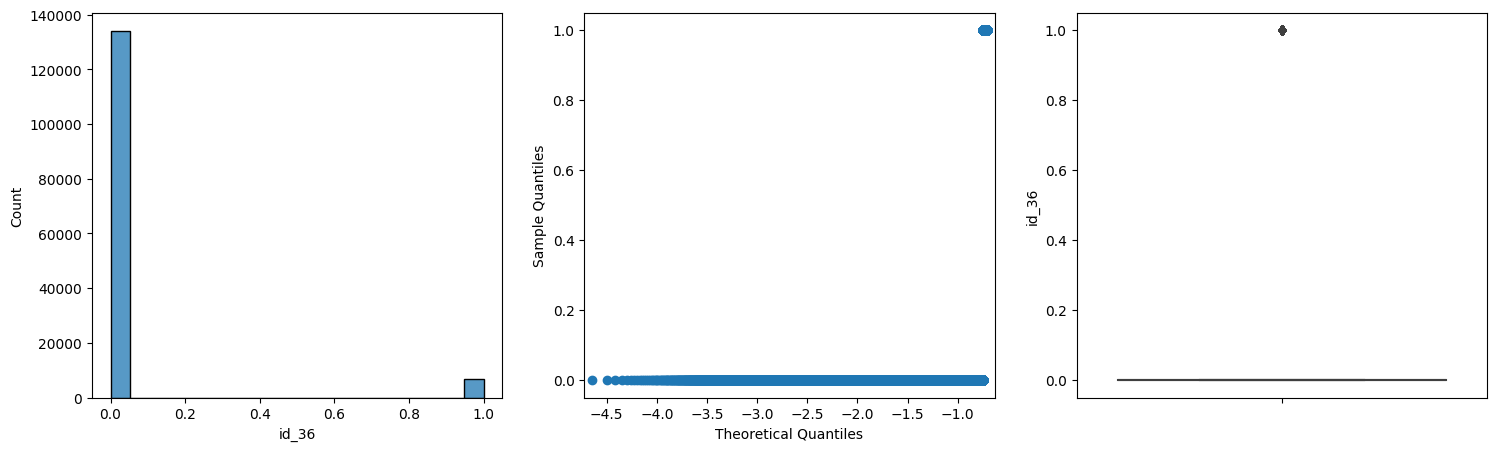

9953

In [152]:
temp_df = train_df[['id_36','isFraud']].copy()
temp_df = Encoder_With_Label(temp_df, col='id_36')
Outlier_Detect_IQR(temp_df, col = 'id_36')

del temp_df
gc.collect()

## id_37

In [153]:
train_df['id_37'].value_counts(normalize=True, dropna=False)

NaN    0.761261
T      0.187036
F      0.051704
Name: id_37, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 1.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 1.0
1.5 the potential outliers below 1.5IQR amount is : 30533
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              30533
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 0.7834308743476868
2.2 the potential outliers above 1.5IQR amount is : 110452
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
1.0              110452
dtype: int64
2.4 the lower bound is 0.7834308743476868
2.5 the potential outliers below 1.5IQR amount is : 30533
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              30533
dtype: int6

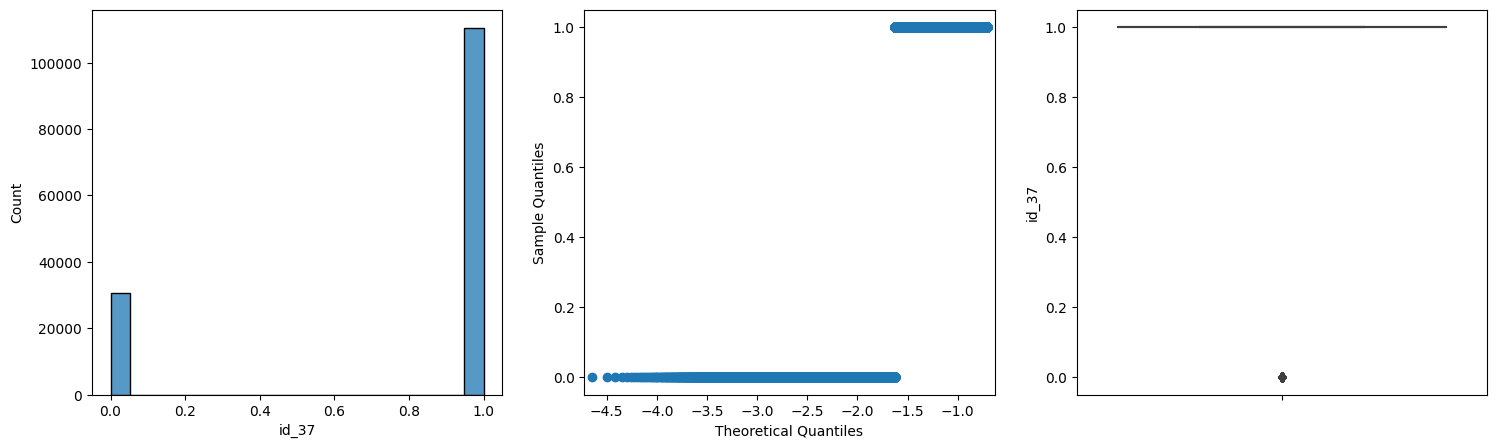

9799

In [154]:
temp_df = train_df[['id_37','isFraud']].copy()
temp_df = Encoder_With_Label(temp_df, col='id_37')
Outlier_Detect_IQR(temp_df, col = 'id_37')

del temp_df
gc.collect()

## id_38

In [155]:
train_df['id_38'].value_counts(normalize=True, dropna=False)

NaN    0.761261
F      0.125177
T      0.113562
Name: id_38, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 1.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is -1.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 1.975674718618393
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -1.024325281381607
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


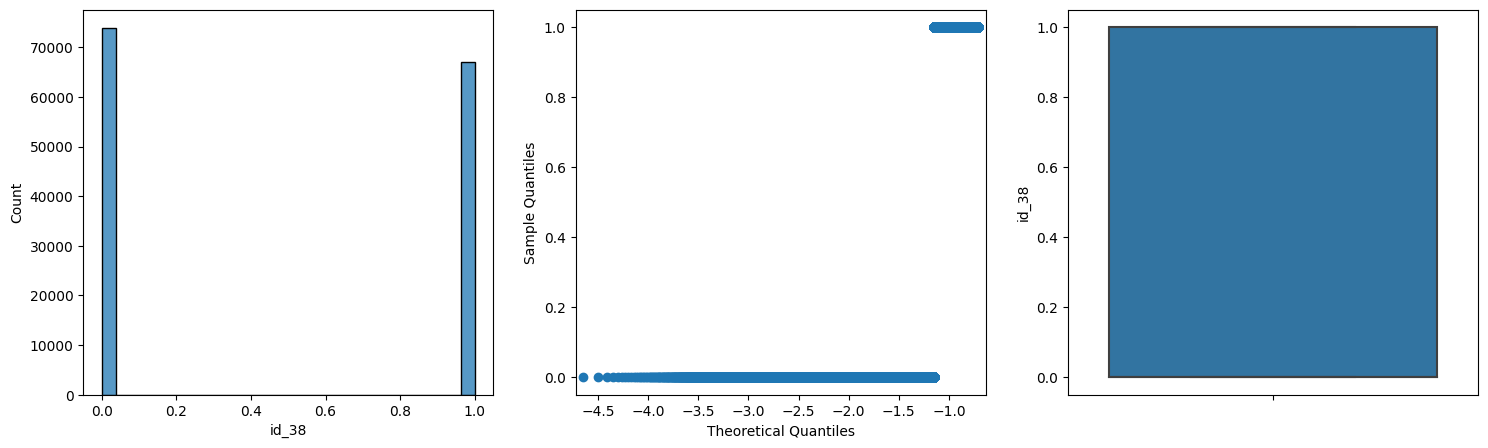

10401

In [156]:
temp_df = train_df[['id_38','isFraud']].copy()
temp_df = Encoder_With_Label(temp_df, col='id_38')
Outlier_Detect_IQR(temp_df, col = 'id_38')

del temp_df
gc.collect()

## Numerical Features

In [157]:
#对 numerical feature 根据median value 做异常值分箱处理
for col in num_col_list:
    
    value_f = np.nanmedian(train_df[col])

    Q1 = train_df[col].quantile(q = 0.25)
    Q3 = train_df[col].quantile(q = 0.75)
    IQR = Q3 - Q1
    upper_bound = value_f + 1.5 * IQR
    lower_bound = value_f - 1.5 * IQR

    #find potential outlier  value
    potential_outliers = [x for x in train_df[col] if x > upper_bound or x < lower_bound]
    #remove duplicate values
    potential_outliers = set(potential_outliers)

    #discretize outliers into a single value,eg:999999,-999999
    train_df[col] = train_df[col].apply(lambda x : 999999 if x in potential_outliers else x)


# Missing Value

## Categorical Features

In [158]:
#impute  Categorical feature with arbitrary value
for col in cate_col_list:
    train_df[col] = Missing_Imputer_Arbitrary(train_df, col = col, method='median')

## Numerical Features

In [159]:
#impute Numerical feature with median
for col  in num_col_list:
    train_df[col] = Missing_Imputer_Median(train_df, col = col)

# Rare Value

In [160]:
# 批量处理特征的稀疏值
for col in tqdm(train_df.columns):
    if col in ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt']:
        continue
    train_df[col]=Rare_Value_Handle(train_df, col=col)

100%|████████████████████████████████████████████████████████████████████████████████| 434/434 [11:19<00:00,  1.57s/it]


In [161]:
train_df.to_csv("../dataset/Cleaned_train.csv",index = False)